# Coursera
## Анализ данных: финальный проект
### Жёлтое такси в Нью-Йорке
#### Михалев Антон

# неделя 05

## исходные данные:
* страница со ссылками: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
* отдельные файлы:
    * за период с 2009-01 до 2019-06
        * https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2009-01.csv
        * ...
        * https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-06.csv
    
    * за период с 2019-07 до 2020-12
        * https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-07.csv
        * ...
        * https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2020-12.csv
    

* ссылка на kaggle - https://inclass.kaggle.com/c/yellowtaxi.

In [1]:
# !pip install pandas
# !pip install fsspec
# !pip install matplotlib
# !pip install scipy
# !pip install basemap
# !pip install folium

In [2]:
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

import itertools as it

import warnings

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.statespace import sarimax

In [4]:
import tqdm

# вспомогательные функции
собраны в начало ноутбука, чтобы было удобнее перезапускать по частям

In [5]:
# тестовые отладочные параметры

__nrows_full = None
__nrows_10 = 10_000

# __nrows_week_01 = __nrows_full
# __nrows_week_01 = __nrows_10

__nrows_pipeline = __nrows_full
# __nrows_pipeline = __nrows_10

# __need_pipeline=True
__need_pipeline=False

# __need_pipeline_2016_05=True
__need_pipeline_2016_05=False
# __need_pipeline_2016_06=True
__need_pipeline_2016_06=False

# __need_save_year=True
__need_save_year=False

__need_load_year=True
# __need_load_year=False

__need_load_more_5=True
# __need_load_more_5=False

# __need_save_region=True
# __need_save_region=False

# __need_load_region=True
# __need_load_region=False

# __nrows_sarimax_fit = __nrows_full
# __nrows_sarimax_fit = 1_000

# __nrows_sarimax_grid = __nrows_full
__nrows_sarimax_grid = 1_000

# __use_1_model = True
__use_1_model = False

__model_rows = __nrows_full
# __model_rows = 5_000



In [6]:
N_pred = 6

K = 23
K_d = 4
stat_len = 24
sum_list = [12, 24, 24*7, 24*7*4] # полдня, сутки, неделю, месяц

skip_begin = K_d * 24
skip_end = K


In [7]:
new_york_coords = {
    'west': -74.25559, 
    'east': -73.70001, 
    'north': 40.91553, 
    'south': 40.49612, 
}


In [8]:
empire_state_building_region = 1231

In [9]:
# получаем список имен файлов по списку годов/месяцев

s3_amazonaws_com_nyc_tlc_link = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'
nyc_tlc_s3_amazonaws_com_link = 'https://nyc-tlc.s3.amazonaws.com/trip+data/'
local_folder = '../data/'

def get_names(use_local, dates):
    result = []
    for year, month in dates:
        if use_local:
            result.append(f'{local_folder}yellow_tripdata_{year}-{month:02}.csv')
        else:
            result.append(f'{nyc_tlc_s3_amazonaws_com_link}yellow_tripdata_{year}-{month:02}.csv')
    
    return result
        

In [10]:
# загружаем весь список файлов в один длинный дата-фрейм

def load_data(names, nrows=None, columns=[]):
    result = None
    
    for i, name in enumerate(names):
        print(f'{i+1}/{len(names)}:{name}')
        
        load_df = pd.read_csv(name, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], nrows=nrows)        
        load_df = drop_columns_except(load_df, columns=columns)
        
        if result is None:
            result = load_df
        else:
            result = pd.concat([
                result, 
                load_df
            ])
    return result

In [11]:
# удаляем колонки, за исключением указанных

def drop_columns_except(data, columns):
    data.drop(columns=list(set(data.columns) - set(columns)), inplace=True)
    return data


In [12]:
# чистим данные

def clear_data(data):
    data.drop(data
              [
                (data['tpep_dropoff_datetime'] == data['tpep_pickup_datetime']) |    
                (data['passenger_count'] <= 0) |    
                (data['trip_distance'] <= 0) |    
                (data['pickup_longitude'] < new_york_coords['west']) | (data['pickup_longitude'] > new_york_coords['east']) |
                (data['pickup_latitude'] < new_york_coords['south']) | (data['pickup_latitude'] > new_york_coords['north'])
              ].index, inplace=True)
    
    return data


In [13]:
# округляем время до часов

def round_time(data):
    data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].dt.floor("H")
    return data

In [14]:
# считаем статистику по регионам

def calc_bins(data, bins):
    bins_result = stats.binned_statistic_2d(data['pickup_longitude'], data['pickup_latitude'], 
                                        None, 
                                        statistic='count', 
                                        bins=bins,
                                        expand_binnumbers=True,
                                       )
    data['region'] = (bins_result.binnumber[0] - 1) * 50 + bins_result.binnumber[1]
    
    return data

In [15]:
# считаем групповую статистику по регионам и часам

def calc_aggregated(data):
    result_aggregated = data.groupby(["tpep_pickup_datetime", "region"]).size().to_frame(name='count')
    
    return result_aggregated

In [16]:
# расширяем групповую статистику до полного набора всех возможных значений

def expand_aggregated(data_aggregated, datetime_all, region_all):
    all_product = pd.DataFrame([[x0, y0] for x0 in datetime_all for y0 in region_all], columns=['tpep_pickup_datetime', 'region'])
    all_product.set_index(['tpep_pickup_datetime', 'region'], inplace=True)
    all_product['count_dummy'] = None
    
    data_aggregated_all = all_product.join(data_aggregated)
    
    data_aggregated_all.drop(columns=['count_dummy'], inplace=True)
    
    data_aggregated_all.fillna(0, inplace=True)
    
    data_aggregated_all.reset_index(inplace=True)

    return data_aggregated_all

In [17]:
# полный цикл обработки для заданного списка файлов

def full_pipeline(names, nrows, bins, data_regions):
    print('(-/6) pipeline begin...')

    result = load_data(names, nrows=nrows, columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'passenger_count', 'trip_distance'])
    print('(1/6) load_data end...')

    result = clear_data(result)
    result = drop_columns_except(result, ['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude'])
    print('(2/6) clear_data end...')
    
    result = round_time(result)
    print('(3/6) round_time end...')
    
    result = calc_bins(result, bins=bins)
    result = drop_columns_except(result, ['tpep_pickup_datetime', 'region'])
    print('(4/6) calc_bins end...')
    
    result_aggregated = calc_aggregated(result)
    print('(5/6) calc_aggregated end...')
        
    result_aggregated_expanded = expand_aggregated(result_aggregated, result_aggregated.index.unique(level='tpep_pickup_datetime'), data_regions['region'].unique())
    result_aggregated_expanded = drop_columns_except(result_aggregated_expanded, ['tpep_pickup_datetime', 'region', 'count'])
    print('(6/6) expand_aggregated end...')
    
    print('(-/-) pipeline end...')
    return result_aggregated_expanded


In [18]:
def calc_date_columns(df, column_prefix=None):
    date_columns = []
    
    column_name = 'date_year'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.year
    date_columns.append(column_name)

    column_name = 'date_month'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.month
    date_columns.append(column_name)

    column_name = 'date_day'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.day
    date_columns.append(column_name)

    column_name = 'date_dayofweek'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.dayofweek
    date_columns.append(column_name)

    column_name = 'date_hour'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.hour
    date_columns.append(column_name)
    
    return df, date_columns


In [19]:
from sklearn.preprocessing import OneHotEncoder

def calc_one_hot_fit_transform(df, column_list):    
    one_hot_columns = []
    one_hot_encoders = {}

    for column_name_original in column_list:
        one_hot_encoders[column_name_original] = OneHotEncoder(handle_unknown='ignore')

        one_hot_encoders[column_name_original].fit(df[column_name_original].values.reshape(-1, 1))
        one_hot_result = one_hot_encoders[column_name_original].transform(df[column_name_original].values.reshape(-1, 1))
        
        for i in range(one_hot_result.shape[1]):
            column_name_one_hot = f'{column_name_original}_{i}'
            df[column_name_one_hot] = one_hot_result[:, i].toarray()
            
            one_hot_columns.append(column_name_one_hot)
        
    return df, one_hot_columns, one_hot_encoders


def calc_one_hot_transform(df, column_list, one_hot_encoders):    
    one_hot_columns = []

    for column_name_original in column_list:
        one_hot_result = one_hot_encoders[column_name_original].transform(df[column_name_original].values.reshape(-1, 1))
        
        for i in range(one_hot_result.shape[1]):
            column_name_one_hot = f'{column_name_original}_{i}'
            df[column_name_one_hot] = one_hot_result[:, i].toarray()
            
            one_hot_columns.append(column_name_one_hot)
        
    return df, one_hot_columns



In [20]:
def add_t_sin_cos(df, k=15, start_t=0, column_prefix=None):
    period_list = [1, 7, 12, 24, 24*7, 24*7*4, 365]
    
    column_t = 't'
    if column_prefix is not None:
        column_t = (column_prefix, column_t)
    
    harmonic_columns = [column_t]
    
    t = np.array(range(start_t, start_t + len(df)))
    df[column_t] = t    
    
    for period in period_list:
        for i in range(1, k+1):
            column_name = f'sin_{i}_{period}'
            if column_prefix is not None:
                column_name = (column_prefix, column_name)
            harmonic_columns.append(column_name)
            df[column_name] = np.sin(df[column_t] * 2 * np.pi * i / period)

            column_name = f'cos_{i}_{period}'
            if column_prefix is not None:
                column_name = (column_prefix, column_name)
            harmonic_columns.append(column_name)
            df[column_name] = np.cos(df[column_t] * 2 * np.pi * i / period)
        
    return df, harmonic_columns


In [21]:
def calc_lags(df, pivot_regions, K, K_d, N_pred, stat_len, sum_list=[]):
    for region_current in tqdm.tqdm(pivot_regions):
        columns_lag_plus = []
        columns_lag_minus = []
        columns_lag_sum = []
        columns_lag_stat = []

        column_name_count = (region_current, f'count')

        for i in range(1, N_pred + 1):
            column_name_lag = f'lag_plus_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            columns_lag_plus.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_count].shift(-i)

        for i in range(1, K + 1):
            column_name_lag = f'lag_minus_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            columns_lag_minus.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_count].shift(i)

        for i in range(1, K_d + 1):
            column_name_lag = f'lag_minus_{i * 24}'
            column_name_lag_full = (region_current, column_name_lag)
            columns_lag_minus.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_count].shift(i * 24)

        for i in sum_list:
            column_name_lag = f'lag_sum_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            columns_lag_sum.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_count].rolling(i).sum()
            df_pivot[column_name_lag_full].fillna(value=df_pivot[column_name_count].cumsum(), inplace=True)

        column_name_lag = f'lag_mean_{stat_len}'
        column_name_lag_full = (region_current, column_name_lag)
        columns_lag_stat.append(column_name_lag)
        df_pivot[column_name_lag_full] = df_pivot[column_name_count].rolling(stat_len).mean()
        
        column_name_lag = f'lag_median_{stat_len}'
        column_name_lag_full = (region_current, column_name_lag)
        columns_lag_stat.append(column_name_lag)
        df_pivot[column_name_lag_full] = df_pivot[column_name_count].rolling(stat_len).median()
        
        column_name_lag = f'lag_std_{stat_len}'
        column_name_lag_full = (region_current, column_name_lag)
        columns_lag_stat.append(column_name_lag)
        df_pivot[column_name_lag_full] = df_pivot[column_name_count].rolling(stat_len).std()
                
    return df, columns_lag_plus, columns_lag_minus, columns_lag_sum, columns_lag_stat


In [22]:
def add_arima_lags_plus(df, df_arima, lags_count, region_n, column_prefix):
    columns_lag_plus = []
    
    for i in range(1, lags_count + 1):
        column_name_lag = f'{column_prefix}_lag_plus_{i}'
        column_name_lag_full = (region_n, column_name_lag)
        columns_lag_plus.append(column_name_lag)
        df[column_name_lag_full] = df_arima.shift(-i)
        
    return df, columns_lag_plus
        
        
def add_arima(df, df_arima, pivot_regions):
    arima_columns = []

    new_column_name_linear_sin_cos_predict = 'linear_sin_cos_predict'
    new_column_name_sarimax = 'sarimax'
    new_column_name_full_predict = 'full_predict'
    
    arima_columns.append(new_column_name_linear_sin_cos_predict)
    arima_columns.append(new_column_name_sarimax)
    arima_columns.append(new_column_name_full_predict)

    for region_current in tqdm.tqdm(pivot_regions):
        old_column_name_linear_sin_cos_predict = f'region_{region_current}_linear_sin_cos_predict'
        df[(region_current, new_column_name_linear_sin_cos_predict)] = df_arima[old_column_name_linear_sin_cos_predict]
        df, columns_lag_plus = add_arima_lags_plus(df, df_arima[old_column_name_linear_sin_cos_predict], lags_count=N_pred, region_n=region_current, column_prefix=new_column_name_linear_sin_cos_predict)
        for column in columns_lag_plus:
            if column not in arima_columns:
                arima_columns.append(column)

        old_column_name_sarimax = f'region_{region_current}_sarimax'
        df[(region_current, new_column_name_sarimax)] = df_arima[old_column_name_sarimax]
        df, columns_lag_plus = add_arima_lags_plus(df, df_arima[old_column_name_sarimax], lags_count=N_pred, region_n=region_current, column_prefix=new_column_name_sarimax)
        for column in columns_lag_plus:
            if column not in arima_columns:
                arima_columns.append(column)

        old_column_name_full_predict = f'region_{region_current}_full_predict'
        df[(region_current, new_column_name_full_predict)] = df_arima[old_column_name_full_predict]
        df, columns_lag_plus = add_arima_lags_plus(df, df_arima[old_column_name_full_predict], lags_count=N_pred, region_n=region_current, column_prefix=new_column_name_full_predict)
        for column in columns_lag_plus:
            if column not in arima_columns:
                arima_columns.append(column)
        
    return df, arima_columns


In [23]:
def unpivot_table(df, common_columns, pivot_regions):
    result = None


    for region_current in tqdm.tqdm(pivot_regions):
        df_new = df[common_columns].copy()
        
        pivot_region_columns = [column for column in df.columns if column[0] == region_current]
        unpivot_region_columns = [('region', column[1]) for column in df.columns if column[0] == region_current]
        
        df_new[('region', 'id')] = region_current
        df_new[unpivot_region_columns] = df[pivot_region_columns]
        
        if result is None:
            result = df_new
        else:
            result = result.append(df_new)
            
    unpivot_region_columns_dict = {
        'id': ('region', 'id'),
        'count': ('region', 'count'),               
        'lags': [c for c in unpivot_region_columns if c != ('region', 'count')],
        'all': [('region', 'id')] + unpivot_region_columns,
    }
            
    return result, common_columns, unpivot_region_columns_dict


In [24]:
def create_submission(result):
    df = []
    for region_n, region_result in result.items():
        for history_end, history_result in region_result.items():
            submission_date_time = datetime.datetime.strftime(history_end, '%Y-%m-%d_%#H')
            for pred_n, pred_value in enumerate(history_result):
                df.append([f'{region_n}_{submission_date_time}_{pred_n + 1}', pred_value]) 

    return pd.DataFrame(df, columns=['id', 'y'])
                           

## список ссылок для загрузки файлов

In [25]:
links_data_all = get_names(False, [(year, month) for year in range(2009, 2020 + 1) for month in range(1, 12 + 1)])

links_data_2_years = get_names(False, [(year, month) for year in range(2019, 2020 + 1) for month in range(1,  12 + 1)])

links_data_6_months = get_names(True, [(2020, month) for month in range(7, 12 + 1)])


In [26]:
# links_data_6_months

In [27]:
# links_data_2_years

In [28]:
# links_data_all

## предсказания ARIMA с предыдущей недели 

In [29]:
df_regions_with_2016_05 = pd.read_csv('df_regions_with_2016_05.csv', parse_dates=['tpep_pickup_datetime'], index_col='tpep_pickup_datetime')
df_regions_with_2016_05

,region_1075_linear_sin_cos_predict,region_1075_sarimax,region_1075_full_predict,region_1076_linear_sin_cos_predict,region_1076_sarimax,region_1076_full_predict,region_1077_linear_sin_cos_predict,region_1077_sarimax,region_1077_full_predict,region_1125_linear_sin_cos_predict,...,region_2069_full_predict,region_2118_linear_sin_cos_predict,region_2118_sarimax,region_2118_full_predict,region_2119_linear_sin_cos_predict,region_2119_sarimax,region_2119_full_predict,region_2168_linear_sin_cos_predict,region_2168_sarimax,region_2168_full_predict
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,34.674200,NaN,NaN,43.898419,NaN,NaN,21.464275,NaN,NaN,43.137808,...,NaN,65.352004,NaN,NaN,27.797134,NaN,NaN,33.292883,NaN,NaN
2015-01-01 01:00:00,18.697536,NaN,NaN,17.197645,NaN,NaN,-0.211476,NaN,NaN,24.300168,...,NaN,48.954936,NaN,NaN,20.214479,NaN,NaN,22.299691,NaN,NaN
2015-01-01 02:00:00,6.440231,NaN,NaN,1.057018,NaN,NaN,-9.017017,NaN,NaN,11.597221,...,NaN,38.448682,NaN,NaN,14.212284,NaN,NaN,15.134856,NaN,NaN
2015-01-01 03:00:00,0.062375,NaN,NaN,-0.852805,NaN,NaN,-3.006860,NaN,NaN,7.187862,...,NaN,34.319196,NaN,NaN,10.417452,NaN,NaN,12.864398,NaN,NaN
2015-01-01 04:00:00,0.524540,NaN,NaN,12.192005,NaN,NaN,16.298624,NaN,NaN,11.340110,...,NaN,35.801883,NaN,NaN,9.039405,NaN,NaN,15.393181,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31 19:00:00,80.291843,20.319649,100.611492,147.419974,47.835283,195.255257,120.799818,54.235303,175.035121,95.458823,...,13.360984,167.076064,33.012108,200.088172,46.441257,5.695722,52.136980,80.057626,17.444130,97.501756
2016-05-31 20:00:00,79.423587,20.309067,99.732654,144.459121,11.925466,156.384587,120.581465,28.357656,148.939121,95.787542,...,17.922702,160.495948,77.032472,237.528420,44.540554,29.707225,74.247778,82.322763,35.701188,118.023951
2016-05-31 21:00:00,74.056096,29.987703,104.043799,131.492561,38.958816,170.451377,107.526874,11.486969,119.013843,88.296478,...,10.959011,147.088821,28.078968,175.167789,40.081102,20.361610,60.442712,79.106447,52.591164,131.697610


In [30]:
df_regions_with_2016_05['region_2168_full_predict'].isna().sum()

744

In [31]:
df_2016_06_102_regions = pd.read_csv('df_2016_06_102_regions.csv', parse_dates=['tpep_pickup_datetime'], index_col='tpep_pickup_datetime')
df_2016_06_102_regions

,region_1075_linear_sin_cos_predict,region_1075_sarimax,region_1075_full_predict,region_1076_linear_sin_cos_predict,region_1076_sarimax,region_1076_full_predict,region_1077_linear_sin_cos_predict,region_1077_sarimax,region_1077_full_predict,region_1125_linear_sin_cos_predict,...,region_2069_full_predict,region_2118_linear_sin_cos_predict,region_2118_sarimax,region_2118_full_predict,region_2119_linear_sin_cos_predict,region_2119_sarimax,region_2119_full_predict,region_2168_linear_sin_cos_predict,region_2168_sarimax,region_2168_full_predict
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-06-01 00:00:00,34.091169,-6.426442,27.664727,46.793650,-6.297638,40.496012,21.438921,-0.234324,21.204597,33.289162,...,6.588861,86.404430,82.080344,168.484774,17.440802,2.722560,20.163362,45.272786,62.637942,107.910728
2016-06-01 01:00:00,19.047263,-9.132764,9.914500,19.740906,-4.946092,14.794814,-2.076595,-1.929912,-4.006507,15.465690,...,3.905313,68.908598,10.246835,79.155433,10.077397,-1.119112,8.958285,33.240464,26.391446,59.631910
2016-06-01 02:00:00,7.526746,-7.049433,0.477312,3.354054,-0.871942,2.482112,-12.743958,-1.534748,-14.278706,4.034388,...,1.386719,56.783336,-34.977447,21.805890,4.389947,5.611523,10.001471,24.781125,-7.034827,17.746298
2016-06-01 03:00:00,1.662953,-7.000056,-5.337103,1.612179,-0.816548,0.795632,-7.950167,-0.534516,-8.484683,1.043718,...,0.371953,50.911634,-30.350340,20.561293,0.911086,4.257331,5.168417,21.214111,-9.156547,12.057564
2016-06-01 04:00:00,2.478838,-4.838803,-2.359965,15.443760,-10.169736,5.274024,11.252452,-5.617420,5.635032,6.615958,...,0.256158,50.920284,-37.376013,13.544271,-0.246439,5.524737,5.278298,22.653327,-9.736827,12.916501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,87.353195,18.323002,105.676196,149.881378,35.546510,185.427889,114.469388,26.142040,140.611428,101.800315,...,13.081922,178.464547,19.229245,197.693792,45.230889,-0.380354,44.850535,77.882136,5.168807,83.050943
2016-06-30 20:00:00,87.576261,14.959959,102.536221,146.437694,25.913166,172.350860,111.452832,20.539004,131.991836,104.842938,...,13.430065,170.968432,70.857723,241.826154,44.202366,22.707528,66.909894,78.623984,16.156339,94.780323
2016-06-30 21:00:00,83.203837,22.512355,105.716192,134.854617,38.214205,173.068822,98.282964,7.597471,105.880435,100.753096,...,12.127711,156.490028,20.587235,177.077264,40.666735,13.676776,54.343511,74.475884,28.282288,102.758172


In [32]:
df_2016_06_102_regions.isna().sum().sum()

0

In [33]:
df_arima_predict = pd.concat([df_regions_with_2016_05, df_2016_06_102_regions])
df_arima_predict

,region_1075_linear_sin_cos_predict,region_1075_sarimax,region_1075_full_predict,region_1076_linear_sin_cos_predict,region_1076_sarimax,region_1076_full_predict,region_1077_linear_sin_cos_predict,region_1077_sarimax,region_1077_full_predict,region_1125_linear_sin_cos_predict,...,region_2069_full_predict,region_2118_linear_sin_cos_predict,region_2118_sarimax,region_2118_full_predict,region_2119_linear_sin_cos_predict,region_2119_sarimax,region_2119_full_predict,region_2168_linear_sin_cos_predict,region_2168_sarimax,region_2168_full_predict
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,34.674200,NaN,NaN,43.898419,NaN,NaN,21.464275,NaN,NaN,43.137808,...,NaN,65.352004,NaN,NaN,27.797134,NaN,NaN,33.292883,NaN,NaN
2015-01-01 01:00:00,18.697536,NaN,NaN,17.197645,NaN,NaN,-0.211476,NaN,NaN,24.300168,...,NaN,48.954936,NaN,NaN,20.214479,NaN,NaN,22.299691,NaN,NaN
2015-01-01 02:00:00,6.440231,NaN,NaN,1.057018,NaN,NaN,-9.017017,NaN,NaN,11.597221,...,NaN,38.448682,NaN,NaN,14.212284,NaN,NaN,15.134856,NaN,NaN
2015-01-01 03:00:00,0.062375,NaN,NaN,-0.852805,NaN,NaN,-3.006860,NaN,NaN,7.187862,...,NaN,34.319196,NaN,NaN,10.417452,NaN,NaN,12.864398,NaN,NaN
2015-01-01 04:00:00,0.524540,NaN,NaN,12.192005,NaN,NaN,16.298624,NaN,NaN,11.340110,...,NaN,35.801883,NaN,NaN,9.039405,NaN,NaN,15.393181,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,87.353195,18.323002,105.676196,149.881378,35.546510,185.427889,114.469388,26.142040,140.611428,101.800315,...,13.081922,178.464547,19.229245,197.693792,45.230889,-0.380354,44.850535,77.882136,5.168807,83.050943
2016-06-30 20:00:00,87.576261,14.959959,102.536221,146.437694,25.913166,172.350860,111.452832,20.539004,131.991836,104.842938,...,13.430065,170.968432,70.857723,241.826154,44.202366,22.707528,66.909894,78.623984,16.156339,94.780323
2016-06-30 21:00:00,83.203837,22.512355,105.716192,134.854617,38.214205,173.068822,98.282964,7.597471,105.880435,100.753096,...,12.127711,156.490028,20.587235,177.077264,40.666735,13.676776,54.343511,74.475884,28.282288,102.758172


In [34]:
len(df_arima_predict), len(df_arima_predict.index.unique())

(13128, 13128)

In [35]:
len(df_arima_predict.columns) / 3

102.0

## регионы

In [36]:
data_regions = pd.read_csv(local_folder + 'regions.csv', sep=';')
data_regions

,region,west,east,south,north
0,1,-74.255590,-74.244478,40.496120,40.504508
1,2,-74.255590,-74.244478,40.504508,40.512896
2,3,-74.255590,-74.244478,40.512896,40.521285
3,4,-74.255590,-74.244478,40.521285,40.529673
4,5,-74.255590,-74.244478,40.529673,40.538061
...,...,...,...,...,...
2495,2496,-73.711122,-73.700010,40.873589,40.881977
2496,2497,-73.711122,-73.700010,40.881977,40.890365
2497,2498,-73.711122,-73.700010,40.890365,40.898754
2498,2499,-73.711122,-73.700010,40.898754,40.907142


In [37]:
# data_regions['west'].value_counts()
# data_regions['east'].value_counts()
# data_regions['south'].value_counts()
# data_regions['north'].value_counts()

In [38]:
# data_regions['west'].unique()
# data_regions['east'].unique()
# data_regions['south'].unique()
# data_regions['north'].unique()

In [39]:
len(data_regions['west'].unique()), len(data_regions['east'].unique()), len(data_regions['south'].unique()), len(data_regions['north'].unique())

(50, 50, 50, 50)

In [40]:
set(data_regions['west'].unique()) - set(data_regions['east'].unique())

{-74.25559}

In [41]:
set(data_regions['south'].unique()) - set(data_regions['north'].unique())

{40.49612}

In [42]:
x_bins = data_regions['west'].append(data_regions['east']).unique()
y_bins = data_regions['south'].append(data_regions['north']).unique()

len(x_bins), len(y_bins)

(51, 51)

### проверим, совпадает ли мой список зон с kaggle

In [43]:
data_sample_solution = pd.read_csv(f'sample_solution.csv')
data_sample_solution['region'] = data_sample_solution['id'].str[:4].astype(int)
len(set(data_sample_solution['region']))

102

In [44]:
data_may = pd.read_csv(f'may.csv')
data_may['region'] = data_may['id'].str[:4].astype(int)
len(set(data_may['region']))

102

In [45]:
set(data_sample_solution['region']) - set(data_may['region'])

set()

In [46]:
data_sample_solution['region'][0], 

(1075,)

In [47]:
regions_102 = sort(list(set(data_may['region'])))
len(regions_102), regions_102

(102,
 array([1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132,
        1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182,
        1183, 1184, 1221, 1222, 1223, 1224, 1225, 1227, 1228, 1229, 1230,
        1231, 1232, 1233, 1234, 1235, 1272, 1273, 1274, 1278, 1279, 1280,
        1281, 1282, 1283, 1284, 1285, 1286, 1287, 1326, 1327, 1331, 1332,
        1333, 1334, 1335, 1336, 1337, 1338, 1339, 1376, 1377, 1378, 1380,
        1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1426, 1431,
        1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1480, 1482, 1483,
        1530, 1532, 1533, 1580, 1630, 1684, 1733, 1734, 1783, 2068, 2069,
        2118, 2119, 2168]))

### Вывод:
* регионы совпадают

## возьмем для обучения полный 2015-й год + январь-апрель 2016 

In [48]:
train_period = '2015-01_2016-04'

In [49]:
dates = [(2015, m) for m in range(1, 12+1)] + [(2016, m) for m in range(1, 4+1)]
dates

[(2015, 1),
 (2015, 2),
 (2015, 3),
 (2015, 4),
 (2015, 5),
 (2015, 6),
 (2015, 7),
 (2015, 8),
 (2015, 9),
 (2015, 10),
 (2015, 11),
 (2015, 12),
 (2016, 1),
 (2016, 2),
 (2016, 3),
 (2016, 4)]

In [50]:
get_names(use_local=True, dates=dates)

['../data/yellow_tripdata_2015-01.csv',
 '../data/yellow_tripdata_2015-02.csv',
 '../data/yellow_tripdata_2015-03.csv',
 '../data/yellow_tripdata_2015-04.csv',
 '../data/yellow_tripdata_2015-05.csv',
 '../data/yellow_tripdata_2015-06.csv',
 '../data/yellow_tripdata_2015-07.csv',
 '../data/yellow_tripdata_2015-08.csv',
 '../data/yellow_tripdata_2015-09.csv',
 '../data/yellow_tripdata_2015-10.csv',
 '../data/yellow_tripdata_2015-11.csv',
 '../data/yellow_tripdata_2015-12.csv',
 '../data/yellow_tripdata_2016-01.csv',
 '../data/yellow_tripdata_2016-02.csv',
 '../data/yellow_tripdata_2016-03.csv',
 '../data/yellow_tripdata_2016-04.csv']

In [51]:
if __need_pipeline:
    data_result = full_pipeline(get_names(use_local=True, dates=dates),
                              nrows=__nrows_pipeline,
                              bins=[x_bins, y_bins],
                              data_regions=data_regions
                             )
    data_result

In [52]:
if __need_save_year:
    data_result.to_csv(f'data_{train_period}.csv', index=False)

In [53]:
if __need_load_year:
    data_result = pd.read_csv(f'data_{train_period}.csv', parse_dates=['tpep_pickup_datetime'])
    
    data_result

In [54]:
data_train = data_result

In [55]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29160000 entries, 0 to 29159999
Data columns (total 3 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[ns]
 1   region                int64         
 2   count                 float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 667.4 MB


In [56]:
data_train.set_index('tpep_pickup_datetime', inplace=True)
data_train

,region,count
tpep_pickup_datetime,,
2015-01-01 00:00:00,1,0.0
2015-01-01 00:00:00,2,0.0
2015-01-01 00:00:00,3,0.0
2015-01-01 00:00:00,4,0.0
2015-01-01 00:00:00,5,0.0
...,...,...
2016-04-30 23:00:00,2496,0.0
2016-04-30 23:00:00,2497,0.0
2016-04-30 23:00:00,2498,0.0


In [57]:
len(data_train['region'].unique()), data_train['region'].unique()

(2500, array([   1,    2,    3, ..., 2498, 2499, 2500], dtype=int64))

In [58]:
len(data_train.index.unique()), data_train.index.unique()

(11664,
 DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
                '2015-01-01 02:00:00', '2015-01-01 03:00:00',
                '2015-01-01 04:00:00', '2015-01-01 05:00:00',
                '2015-01-01 06:00:00', '2015-01-01 07:00:00',
                '2015-01-01 08:00:00', '2015-01-01 09:00:00',
                ...
                '2016-04-30 14:00:00', '2016-04-30 15:00:00',
                '2016-04-30 16:00:00', '2016-04-30 17:00:00',
                '2016-04-30 18:00:00', '2016-04-30 19:00:00',
                '2016-04-30 20:00:00', '2016-04-30 21:00:00',
                '2016-04-30 22:00:00', '2016-04-30 23:00:00'],
               dtype='datetime64[ns]', name='tpep_pickup_datetime', length=11664, freq=None))

## для визуальной проверки - посмотрим на регион из предыдущего задания

In [59]:
empire_state_building_region

1231

In [60]:
count_region = data_train[data_train['region'] == empire_state_building_region]['count']
count_region

tpep_pickup_datetime
2015-01-01 00:00:00    821.0
2015-01-01 01:00:00    691.0
2015-01-01 02:00:00    565.0
2015-01-01 03:00:00    573.0
2015-01-01 04:00:00    417.0
                       ...  
2016-04-30 19:00:00    892.0
2016-04-30 20:00:00    779.0
2016-04-30 21:00:00    793.0
2016-04-30 22:00:00    884.0
2016-04-30 23:00:00    785.0
Name: count, Length: 11664, dtype: float64

In [61]:
count_region.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2016-04-30 14:00:00', '2016-04-30 15:00:00',
               '2016-04-30 16:00:00', '2016-04-30 17:00:00',
               '2016-04-30 18:00:00', '2016-04-30 19:00:00',
               '2016-04-30 20:00:00', '2016-04-30 21:00:00',
               '2016-04-30 22:00:00', '2016-04-30 23:00:00'],
              dtype='datetime64[ns]', name='tpep_pickup_datetime', length=11664, freq=None)

<AxesSubplot:xlabel='tpep_pickup_datetime'>

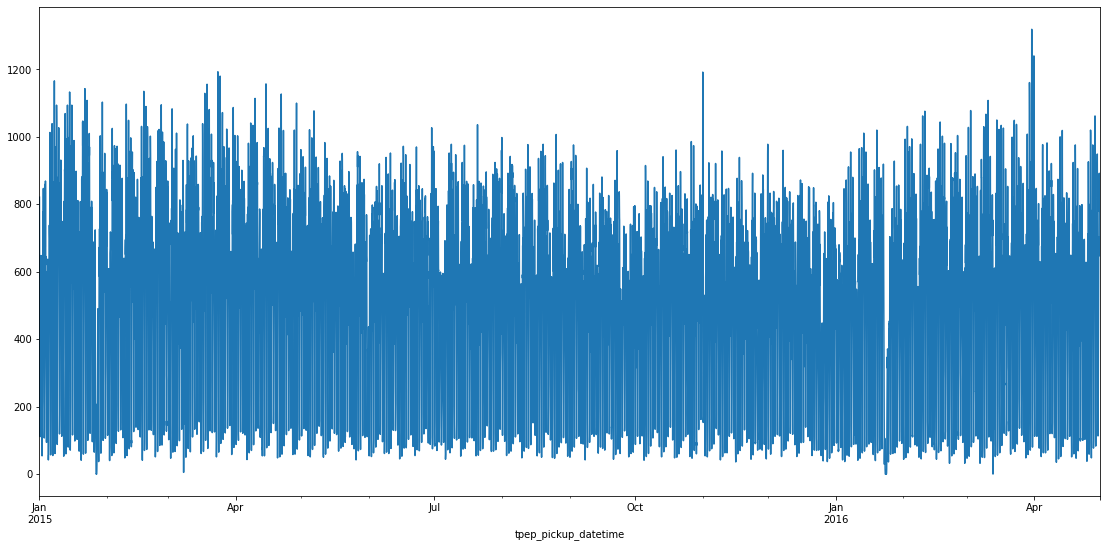

In [62]:
count_region.plot(figsize=(19, 9))

In [63]:
count_region.sum()

6085612.0

<AxesSubplot:>

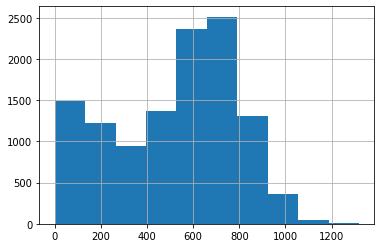

In [64]:
count_region.hist()

### Вывод:
* визуально графики совпадают с тем, что было

## возьмем для теста - май 2016, 
## для валидации - июнь 2016 

In [65]:
%%time

test_period = '2016-05'
dates = [(2016, 5)]

if __need_pipeline_2016_05:
    data_2016_05 = full_pipeline(get_names(use_local=True, dates=dates),
                              nrows=__nrows_pipeline,
                              bins=[x_bins, y_bins],
                              data_regions=data_regions
                             )
    data_2016_05.to_csv(f'data_{test_period}.csv', index=False)
else:
    data_2016_05 = pd.read_csv(f'data_{test_period}.csv', parse_dates=['tpep_pickup_datetime'])
    
data_2016_05.set_index('tpep_pickup_datetime', inplace=True)

data_2016_05

# Wall time: 2min 5s

Wall time: 756 ms


,region,count
tpep_pickup_datetime,,
2016-05-01 00:00:00,1,0.0
2016-05-01 00:00:00,2,0.0
2016-05-01 00:00:00,3,0.0
2016-05-01 00:00:00,4,0.0
2016-05-01 00:00:00,5,0.0
...,...,...
2016-05-31 23:00:00,2496,0.0
2016-05-31 23:00:00,2497,0.0
2016-05-31 23:00:00,2498,0.0


In [66]:
%%time

test_period = '2016-06'
dates = [(2016, 6)]

if __need_pipeline_2016_06:
    data_2016_06 = full_pipeline(get_names(use_local=True, dates=dates),
                              nrows=__nrows_pipeline,
                              bins=[x_bins, y_bins],
                              data_regions=data_regions
                             )
    data_2016_06.to_csv(f'data_{test_period}.csv', index=False)
else:
    data_2016_06 = pd.read_csv(f'data_{test_period}.csv', parse_dates=['tpep_pickup_datetime'])
    
data_2016_06.set_index('tpep_pickup_datetime', inplace=True)

data_2016_06

# Wall time: 2min 5s

Wall time: 728 ms


,region,count
tpep_pickup_datetime,,
2016-06-01 00:00:00,1,0.0
2016-06-01 00:00:00,2,0.0
2016-06-01 00:00:00,3,0.0
2016-06-01 00:00:00,4,0.0
2016-06-01 00:00:00,5,0.0
...,...,...
2016-06-30 23:00:00,2496,0.0
2016-06-30 23:00:00,2497,0.0
2016-06-30 23:00:00,2498,0.0


### найдем ячейки "которые были отобраны на второй неделе":
* "отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся"
* правильный ответ: 102

In [67]:
if __need_load_more_5:
    data_2016_05_more_5 = pd.read_csv(f'data_2016_05_more_5.csv')
    data_2016_05_more_5

In [68]:
len(set(data_2016_05_more_5['region']))

102

In [69]:
region_102 = pd.Series(data_2016_05_more_5['region'].unique(), name='region')
region_102

0      1075
1      1076
2      1077
3      1125
4      1126
       ... 
97     2068
98     2069
99     2118
100    2119
101    2168
Name: region, Length: 102, dtype: int64

## соберем train + test + val в один большой датасет

In [70]:
data_all = data_train[data_train['region'].isin(region_102)].append(data_2016_05[data_2016_05['region'].isin(region_102)]).append(data_2016_06[data_2016_06['region'].isin(region_102)])
data_all

,region,count
tpep_pickup_datetime,,
2015-01-01 00:00:00,1075,78.0
2015-01-01 00:00:00,1076,89.0
2015-01-01 00:00:00,1077,44.0
2015-01-01 00:00:00,1125,74.0
2015-01-01 00:00:00,1126,223.0
...,...,...
2016-06-30 23:00:00,2068,147.0
2016-06-30 23:00:00,2069,38.0
2016-06-30 23:00:00,2118,173.0


In [71]:
len(data_all.index.unique()), len(data_train.index.unique()) +len(data_2016_05.index.unique()) + len(data_2016_06.index.unique()),  

(13128, 13128)

In [72]:
len(data_all['region'].unique()), len(region_102.unique()),

(102, 102)

In [73]:
len(df_arima_predict), len(df_arima_predict.index.unique())

(13128, 13128)

### соберем сводную таблицу в нужном формате

In [74]:
df_pivot = data_all.pivot(columns=['region'], values=['count'])
df_pivot.fillna(0, inplace=True)
df_pivot

count                                                   \
region                 1075   1076   1077   1125   1126   1127   1128   1129   
tpep_pickup_datetime                                                           
2015-01-01 00:00:00    78.0   89.0   44.0   74.0  223.0  363.0  383.0  516.0   
2015-01-01 01:00:00   105.0  122.0   42.0   91.0  348.0  386.0  345.0  376.0   
2015-01-01 02:00:00    80.0  122.0   26.0   99.0  280.0  300.0  284.0  337.0   
2015-01-01 03:00:00    52.0   81.0   14.0   58.0  238.0  342.0  242.0  305.0   
2015-01-01 04:00:00    19.0   40.0   11.0   56.0  130.0  238.0  216.0  265.0   
...                     ...    ...    ...    ...    ...    ...    ...    ...   
2016-06-30 19:00:00   116.0  190.0  135.0  132.0  395.0  308.0  401.0  336.0   
2016-06-30 20:00:00   104.0  142.0  149.0  141.0  333.0  368.0  390.0  385.0   
2016-06-30 21:00:00   151.0  162.0  145.0  135.0  359.0  422.0  460.0  541.0   
2016-06-30 22:00:00   106.0  168.0  103.0  125.0  317.0  476.0  405.0  508.0   
2016-06-30 23:00:00    85.0  130.0   86.0  113.0  256.0  428.0  483.0  531.0   

                                    ...                                        \
region                 1130   1131  ...  1630  1684 1733   1734   1783   2068   
tpep_pickup_datetime                ...                                         
2015-01-01 00:00:00   733.0  246.0  ...  12.0   0.0  1.0   23.0   30.0   28.0   
2015-01-01 01:00:00   462.0  174.0  ...  16.0   0.0  1.0    0.0    3.0    4.0   
2015-01-01 02:00:00   351.0  129.0  ...  32.0   0.0  1.0    1.0    1.0    0.0   
2015-01-01 03:00:00   246.0  117.0  ...  28.0   0.0  1.0    0.0    0.0    1.0   
2015-01-01 04:00:00   276.0   87.0  ...  35.0   0.0  2.0    1.0    3.0    3.0   
...                     ...    ...  ...   ...   ...  ...    ...    ...    ...   
2016-06-30 19:00:00   496.0  260.0  ...   2.0  44.0  4.0  297.0  311.0  104.0   
2016-06-30 20:00:00   560.0  247.0  ...   1.0  27.0  7.0  288.0  344.0  103.0   
2016-06-30 21:00:00   672.0  259.0  ...   2.0  21.0  9.0  287.0  307.0  185.0   
2016-06-30 22:00:00   578.0  259.0  ...   3.0  19.0  5.0  358.0  387.0  169.0   
2016-06-30 23:00:00   631.0  210.0  ...   9.0   0.0  7.0  323.0  110.0  147.0   

                                                
region                2069   2118   2119  2168  
tpep_pickup_datetime                            
2015-01-01 00:00:00    2.0   73.0    6.0  50.0  
2015-01-01 01:00:00    0.0   83.0    0.0   1.0  
2015-01-01 02:00:00    0.0    4.0    0.0   0.0  
2015-01-01 03:00:00    0.0   17.0    0.0   0.0  
2015-01-01 04:00:00    0.0    3.0    0.0  14.0  
...                    ...    ...    ...   ...  
2016-06-30 19:00:00    9.0  142.0   96.0   1.0  
2016-06-30 20:00:00   24.0  209.0  145.0   0.0  
2016-06-30 21:00:00    9.0  213.0  142.0   1.0  
2016-06-30 22:00:00   12.0  206.0  146.0   0.0  
2016-06-30 23:00:00   38.0  173.0  119.0   0.0  

[13128 rows x 102 columns]

### проверим суммы с исходной таблицей

In [75]:
len(data_all.index.unique()), len(df_pivot), df_pivot.index

(13128,
 13128,
 DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
                '2015-01-01 02:00:00', '2015-01-01 03:00:00',
                '2015-01-01 04:00:00', '2015-01-01 05:00:00',
                '2015-01-01 06:00:00', '2015-01-01 07:00:00',
                '2015-01-01 08:00:00', '2015-01-01 09:00:00',
                ...
                '2016-06-30 14:00:00', '2016-06-30 15:00:00',
                '2016-06-30 16:00:00', '2016-06-30 17:00:00',
                '2016-06-30 18:00:00', '2016-06-30 19:00:00',
                '2016-06-30 20:00:00', '2016-06-30 21:00:00',
                '2016-06-30 22:00:00', '2016-06-30 23:00:00'],
               dtype='datetime64[ns]', name='tpep_pickup_datetime', length=13128, freq=None))

In [76]:
len(data_all['region'].unique()), len(df_pivot.columns), df_pivot.columns

(102,
 102,
 MultiIndex([('count', 1075),
             ('count', 1076),
             ('count', 1077),
             ('count', 1125),
             ('count', 1126),
             ('count', 1127),
             ('count', 1128),
             ('count', 1129),
             ('count', 1130),
             ('count', 1131),
             ...
             ('count', 1630),
             ('count', 1684),
             ('count', 1733),
             ('count', 1734),
             ('count', 1783),
             ('count', 2068),
             ('count', 2069),
             ('count', 2118),
             ('count', 2119),
             ('count', 2168)],
            names=[None, 'region'], length=102))

In [77]:
df_pivot['count', empire_state_building_region]

tpep_pickup_datetime
2015-01-01 00:00:00     821.0
2015-01-01 01:00:00     691.0
2015-01-01 02:00:00     565.0
2015-01-01 03:00:00     573.0
2015-01-01 04:00:00     417.0
                        ...  
2016-06-30 19:00:00     968.0
2016-06-30 20:00:00     924.0
2016-06-30 21:00:00    1057.0
2016-06-30 22:00:00     903.0
2016-06-30 23:00:00     899.0
Name: (count, 1231), Length: 13128, dtype: float64

<AxesSubplot:xlabel='tpep_pickup_datetime'>

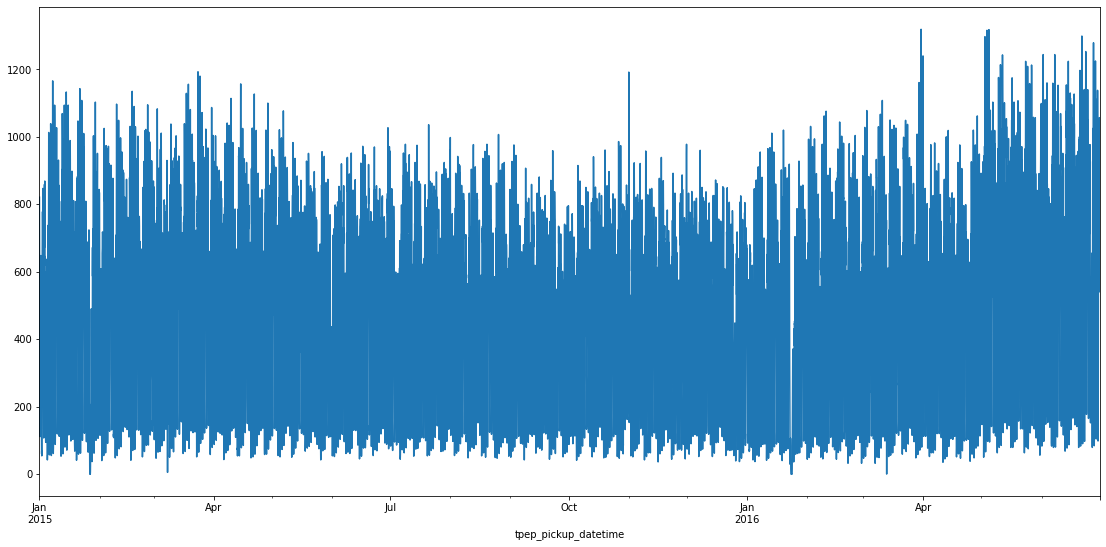

In [78]:
df_pivot['count', empire_state_building_region].plot(figsize=(19, 9))

<AxesSubplot:>

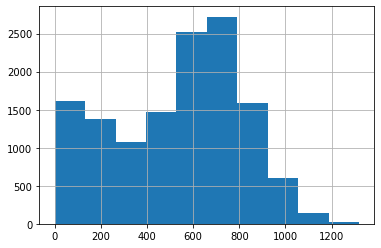

In [79]:
df_pivot['count', empire_state_building_region].hist()

In [80]:
df_pivot.sum().sum(), data_all['count'].sum()

(159334873.0, 159334873.0)

### Вывод:
* датасет составлен правильно

# 1. Для каждой из шести задач прогнозирования $\hat{y}_{T+i|T}$ сформируйте выборки. Откликом будет $y_{T+i}$ при всевозможных значениях T, а признаки можно использовать следующие:
* идентификатор географической зоны — категориальный
* год, месяц, день месяца, день недели, час — эти признаки можно пробовать брать и категориальными, и непрерывными, можно даже и так, и так
* синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA
* сами значения прогнозов $ARIMA \hat{y}_{T+i|T}^{ARIMA} $
* количество поездок из рассматриваемого района в моменты времени $y_T, y_{T-1}, \dots, y_{T-K}$ (параметр K можно подбирать; попробуйте начать, например, с 6)
* количество поездок из рассматриваемого района в моменты времени $y_{T-24}, y_{T-48}, \dots, y_{T-24*K_d}$  (параметр $K_d$ можно подбирать; попробуйте начать, например, с 2)
* суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц

Будьте внимательны при создании признаков — все факторы должны быть рассчитаны без использования информации из будущего: при прогнозировании $\hat{y}_{T+i|T}$ вы можете учитывать только значения y до момента времени T включительно.

In [81]:
print(N_pred)

# K начал с 6, потом увеличил до 23
# K_d начал с 2, увеличил до 4
print(K, K_d)

print(sum_list)
print(stat_len)

print(skip_begin, skip_end)


6
23 4
[12, 24, 168, 672]
24
96 23


In [82]:
common_columns = []
regression_columns = []
target_columns = []

### так как исходные данные для всех моделей одинаковы, а отличаются только отклики - будем хранить в одной матрице и исходные данные, и все 6 откликов

In [83]:
if df_pivot.columns[0][1] != 'count':
    pivot_regions = [c[1] for c in df_pivot.columns]
    df_pivot.columns = pd.MultiIndex.from_tuples([(c, 'count') for c in pivot_regions])
df_pivot

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
,count,count,count,count,count,count,count,count,count,count,...,count,count,count,count,count,count,count,count,count,count
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,78.0,89.0,44.0,74.0,223.0,363.0,383.0,516.0,733.0,246.0,...,12.0,0.0,1.0,23.0,30.0,28.0,2.0,73.0,6.0,50.0
2015-01-01 01:00:00,105.0,122.0,42.0,91.0,348.0,386.0,345.0,376.0,462.0,174.0,...,16.0,0.0,1.0,0.0,3.0,4.0,0.0,83.0,0.0,1.0
2015-01-01 02:00:00,80.0,122.0,26.0,99.0,280.0,300.0,284.0,337.0,351.0,129.0,...,32.0,0.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0
2015-01-01 03:00:00,52.0,81.0,14.0,58.0,238.0,342.0,242.0,305.0,246.0,117.0,...,28.0,0.0,1.0,0.0,0.0,1.0,0.0,17.0,0.0,0.0
2015-01-01 04:00:00,19.0,40.0,11.0,56.0,130.0,238.0,216.0,265.0,276.0,87.0,...,35.0,0.0,2.0,1.0,3.0,3.0,0.0,3.0,0.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,116.0,190.0,135.0,132.0,395.0,308.0,401.0,336.0,496.0,260.0,...,2.0,44.0,4.0,297.0,311.0,104.0,9.0,142.0,96.0,1.0
2016-06-30 20:00:00,104.0,142.0,149.0,141.0,333.0,368.0,390.0,385.0,560.0,247.0,...,1.0,27.0,7.0,288.0,344.0,103.0,24.0,209.0,145.0,0.0


In [84]:
len(pivot_regions), pivot_regions[0], pivot_regions[-1]

(102, 1075, 2168)

### год, месяц, день месяца, день недели, час - непрерывные

In [85]:
df_pivot, date_columns = calc_date_columns(df_pivot, column_prefix='COMMON')
df_pivot

1075   1076   1077   1125   1126   1127   1128   1129  \
                      count  count  count  count  count  count  count  count   
tpep_pickup_datetime                                                           
2015-01-01 00:00:00    78.0   89.0   44.0   74.0  223.0  363.0  383.0  516.0   
2015-01-01 01:00:00   105.0  122.0   42.0   91.0  348.0  386.0  345.0  376.0   
2015-01-01 02:00:00    80.0  122.0   26.0   99.0  280.0  300.0  284.0  337.0   
2015-01-01 03:00:00    52.0   81.0   14.0   58.0  238.0  342.0  242.0  305.0   
2015-01-01 04:00:00    19.0   40.0   11.0   56.0  130.0  238.0  216.0  265.0   
...                     ...    ...    ...    ...    ...    ...    ...    ...   
2016-06-30 19:00:00   116.0  190.0  135.0  132.0  395.0  308.0  401.0  336.0   
2016-06-30 20:00:00   104.0  142.0  149.0  141.0  333.0  368.0  390.0  385.0   
2016-06-30 21:00:00   151.0  162.0  145.0  135.0  359.0  422.0  460.0  541.0   
2016-06-30 22:00:00   106.0  168.0  103.0  125.0  317.0  476.0  405.0  508.0   
2016-06-30 23:00:00    85.0  130.0   86.0  113.0  256.0  428.0  483.0  531.0   

                       1130   1131  ...   2068  2069   2118   2119  2168  \
                      count  count  ...  count count  count  count count   
tpep_pickup_datetime                ...                                    
2015-01-01 00:00:00   733.0  246.0  ...   28.0   2.0   73.0    6.0  50.0   
2015-01-01 01:00:00   462.0  174.0  ...    4.0   0.0   83.0    0.0   1.0   
2015-01-01 02:00:00   351.0  129.0  ...    0.0   0.0    4.0    0.0   0.0   
2015-01-01 03:00:00   246.0  117.0  ...    1.0   0.0   17.0    0.0   0.0   
2015-01-01 04:00:00   276.0   87.0  ...    3.0   0.0    3.0    0.0  14.0   
...                     ...    ...  ...    ...   ...    ...    ...   ...   
2016-06-30 19:00:00   496.0  260.0  ...  104.0   9.0  142.0   96.0   1.0   
2016-06-30 20:00:00   560.0  247.0  ...  103.0  24.0  209.0  145.0   0.0   
2016-06-30 21:00:00   672.0  259.0  ...  185.0   9.0  213.0  142.0   1.0   
2016-06-30 22:00:00   578.0  259.0  ...  169.0  12.0  206.0  146.0   0.0   
2016-06-30 23:00:00   631.0  210.0  ...  147.0  38.0  173.0  119.0   0.0   

                        COMMON                                               
                     date_year date_month date_day date_dayofweek date_hour  
tpep_pickup_datetime                                                         
2015-01-01 00:00:00       2015          1        1              3         0  
2015-01-01 01:00:00       2015          1        1              3         1  
2015-01-01 02:00:00       2015          1        1              3         2  
2015-01-01 03:00:00       2015          1        1              3         3  
2015-01-01 04:00:00       2015          1        1              3         4  
...                        ...        ...      ...            ...       ...  
2016-06-30 19:00:00       2016          6       30              3        19  
2016-06-30 20:00:00       2016          6       30              3        20  
2016-06-30 21:00:00       2016          6       30              3        21  
2016-06-30 22:00:00       2016          6       30              3        22  
2016-06-30 23:00:00       2016          6       30              3        23  

[13128 rows x 107 columns]

In [86]:
common_columns.extend(date_columns)
common_columns

[('COMMON', 'date_year'),
 ('COMMON', 'date_month'),
 ('COMMON', 'date_day'),
 ('COMMON', 'date_dayofweek'),
 ('COMMON', 'date_hour')]

In [87]:
df_pivot.columns

MultiIndex([(    1075,          'count'),
            (    1076,          'count'),
            (    1077,          'count'),
            (    1125,          'count'),
            (    1126,          'count'),
            (    1127,          'count'),
            (    1128,          'count'),
            (    1129,          'count'),
            (    1130,          'count'),
            (    1131,          'count'),
            ...
            (    2068,          'count'),
            (    2069,          'count'),
            (    2118,          'count'),
            (    2119,          'count'),
            (    2168,          'count'),
            ('COMMON',      'date_year'),
            ('COMMON',     'date_month'),
            ('COMMON',       'date_day'),
            ('COMMON', 'date_dayofweek'),
            ('COMMON',      'date_hour')],
           length=107)

In [88]:
regression_columns.extend(date_columns)
regression_columns

[('COMMON', 'date_year'),
 ('COMMON', 'date_month'),
 ('COMMON', 'date_day'),
 ('COMMON', 'date_dayofweek'),
 ('COMMON', 'date_hour')]

### синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA
* изначально взяты только недельные гармоники (168) с коэффициентами от 1 до 15
* затем добавлены гармоники суточные/недельные/месячные/годовые

In [89]:
df_pivot, harmonic_columns = add_t_sin_cos(df_pivot, column_prefix='COMMON')
df_pivot

1075   1076   1077   1125   1126   1127   1128   1129  \
                      count  count  count  count  count  count  count  count   
tpep_pickup_datetime                                                           
2015-01-01 00:00:00    78.0   89.0   44.0   74.0  223.0  363.0  383.0  516.0   
2015-01-01 01:00:00   105.0  122.0   42.0   91.0  348.0  386.0  345.0  376.0   
2015-01-01 02:00:00    80.0  122.0   26.0   99.0  280.0  300.0  284.0  337.0   
2015-01-01 03:00:00    52.0   81.0   14.0   58.0  238.0  342.0  242.0  305.0   
2015-01-01 04:00:00    19.0   40.0   11.0   56.0  130.0  238.0  216.0  265.0   
...                     ...    ...    ...    ...    ...    ...    ...    ...   
2016-06-30 19:00:00   116.0  190.0  135.0  132.0  395.0  308.0  401.0  336.0   
2016-06-30 20:00:00   104.0  142.0  149.0  141.0  333.0  368.0  390.0  385.0   
2016-06-30 21:00:00   151.0  162.0  145.0  135.0  359.0  422.0  460.0  541.0   
2016-06-30 22:00:00   106.0  168.0  103.0  125.0  317.0  476.0  405.0  508.0   
2016-06-30 23:00:00    85.0  130.0   86.0  113.0  256.0  428.0  483.0  531.0   

                       1130   1131  ...     COMMON                        \
                      count  count  ... sin_11_365 cos_11_365 sin_12_365   
tpep_pickup_datetime                ...                                    
2015-01-01 00:00:00   733.0  246.0  ...   0.000000   1.000000   0.000000   
2015-01-01 01:00:00   462.0  174.0  ...   0.188227   0.982126   0.205104   
2015-01-01 02:00:00   351.0  129.0  ...   0.369725   0.929141   0.401488   
2015-01-01 03:00:00   246.0  117.0  ...   0.538005   0.842942   0.580800   
2015-01-01 04:00:00   276.0   87.0  ...   0.687053   0.726608   0.735417   
...                     ...    ...  ...        ...        ...        ...   
2016-06-30 19:00:00   496.0  260.0  ...   0.077386  -0.997001   0.361714   
2016-06-30 20:00:00   560.0  247.0  ...  -0.111659  -0.993747   0.162807   
2016-06-30 21:00:00   672.0  259.0  ...  -0.296713  -0.954967  -0.043022   
2016-06-30 22:00:00   578.0  259.0  ...  -0.471160  -0.882048  -0.247022   
2016-06-30 23:00:00   631.0  210.0  ...  -0.628763  -0.777597  -0.440519   

                                                                             \
                     cos_12_365 sin_13_365 cos_13_365 sin_14_365 cos_14_365   
tpep_pickup_datetime                                                          
2015-01-01 00:00:00    1.000000   0.000000   1.000000   0.000000   1.000000   
2015-01-01 01:00:00    0.978740   0.221922   0.975065   0.238673   0.971100   
2015-01-01 02:00:00    0.915864   0.432776   0.901502   0.463550   0.886071   
2015-01-01 03:00:00    0.814046   0.622047   0.782980   0.661635   0.749826   
2015-01-01 04:00:00    0.677615   0.780296   0.625411   0.821477   0.570242   
...                         ...        ...        ...        ...        ...   
2016-06-30 19:00:00   -0.932289   0.615285  -0.788305   0.816538  -0.577292   
2016-06-30 20:00:00   -0.986658   0.425000  -0.905193   0.655156  -0.755493   
2016-06-30 21:00:00   -0.999074   0.213521  -0.976938   0.455907  -0.890028   
2016-06-30 22:00:00   -0.969010  -0.008607  -0.999963   0.230306  -0.973118   
2016-06-30 23:00:00   -0.897743  -0.230306  -0.973118  -0.008607  -0.999963   

                                            
                     sin_15_365 cos_15_365  
tpep_pickup_datetime                        
2015-01-01 00:00:00    0.000000   1.000000  
2015-01-01 01:00:00    0.255353   0.966848  
2015-01-01 02:00:00    0.493776   0.869589  
2015-01-01 03:00:00    0.699458   0.714673  
2015-01-01 04:00:00    0.858764   0.512371  
...                         ...        ...  
2016-06-30 19:00:00    0.948362  -0.317191  
2016-06-30 20:00:00    0.835925  -0.548843  
2016-06-30 21:00:00    0.668064  -0.744104  
2016-06-30 22:00:00    0.455907  -0.890028  
2016-06-30 23:00:00    0.213521  -0.976938  

[13128 rows x 318 columns]

In [90]:
common_columns.extend(harmonic_columns)
len(common_columns)

216

In [91]:
regression_columns.extend(harmonic_columns)
len(regression_columns)

216

### сами значения прогнозов ARIMA $\hat{y}_{T+i|T}^{ARIMA} $
для каждой точки времени беру следующие данные:
* прогноз ARIMA непосредственно в этой точке:
    * предсказание линейной регрессии (экзогенный признак для ARIMA)
    * предсказание ARIMA на остатки после линейной регрессии
    * итоговая сумма (линейная регрессия + ARIMA)
* прогноз таких же данных на 6 лагов вперед


In [92]:
df_pivot, arima_columns = add_arima(df_pivot, df_arima_predict, pivot_regions, )
df_pivot.fillna(0, inplace=True)
df_pivot

100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:02<00:00, 38.89it/s]


1075   1076   1077   1125   1126   1127   1128   1129  \
                      count  count  count  count  count  count  count  count   
tpep_pickup_datetime                                                           
2015-01-01 00:00:00    78.0   89.0   44.0   74.0  223.0  363.0  383.0  516.0   
2015-01-01 01:00:00   105.0  122.0   42.0   91.0  348.0  386.0  345.0  376.0   
2015-01-01 02:00:00    80.0  122.0   26.0   99.0  280.0  300.0  284.0  337.0   
2015-01-01 03:00:00    52.0   81.0   14.0   58.0  238.0  342.0  242.0  305.0   
2015-01-01 04:00:00    19.0   40.0   11.0   56.0  130.0  238.0  216.0  265.0   
...                     ...    ...    ...    ...    ...    ...    ...    ...   
2016-06-30 19:00:00   116.0  190.0  135.0  132.0  395.0  308.0  401.0  336.0   
2016-06-30 20:00:00   104.0  142.0  149.0  141.0  333.0  368.0  390.0  385.0   
2016-06-30 21:00:00   151.0  162.0  145.0  135.0  359.0  422.0  460.0  541.0   
2016-06-30 22:00:00   106.0  168.0  103.0  125.0  317.0  476.0  405.0  508.0   
2016-06-30 23:00:00    85.0  130.0   86.0  113.0  256.0  428.0  483.0  531.0   

                       1130   1131  ...               2168                     \
                      count  count  ... sarimax_lag_plus_4 sarimax_lag_plus_5   
tpep_pickup_datetime                ...                                         
2015-01-01 00:00:00   733.0  246.0  ...           0.000000                0.0   
2015-01-01 01:00:00   462.0  174.0  ...           0.000000                0.0   
2015-01-01 02:00:00   351.0  129.0  ...           0.000000                0.0   
2015-01-01 03:00:00   246.0  117.0  ...           0.000000                0.0   
2015-01-01 04:00:00   276.0   87.0  ...           0.000000                0.0   
...                     ...    ...  ...                ...                ...   
2016-06-30 19:00:00   496.0  260.0  ...          22.726372                0.0   
2016-06-30 20:00:00   560.0  247.0  ...           0.000000                0.0   
2016-06-30 21:00:00   672.0  259.0  ...           0.000000                0.0   
2016-06-30 22:00:00   578.0  259.0  ...           0.000000                0.0   
2016-06-30 23:00:00   631.0  210.0  ...           0.000000                0.0   

                                                                              \
                     sarimax_lag_plus_6 full_predict full_predict_lag_plus_1   
tpep_pickup_datetime                                                           
2015-01-01 00:00:00                 0.0     0.000000                0.000000   
2015-01-01 01:00:00                 0.0     0.000000                0.000000   
2015-01-01 02:00:00                 0.0     0.000000                0.000000   
2015-01-01 03:00:00                 0.0     0.000000                0.000000   
2015-01-01 04:00:00                 0.0     0.000000                0.000000   
...                                 ...          ...                     ...   
2016-06-30 19:00:00                 0.0    83.050943               94.780323   
2016-06-30 20:00:00                 0.0    94.780323              102.758172   
2016-06-30 21:00:00                 0.0   102.758172               99.555163   
2016-06-30 22:00:00                 0.0    99.555163               77.481161   
2016-06-30 23:00:00                 0.0    77.481161                0.000000   

                                                                      \
                     full_predict_lag_plus_2 full_predict_lag_plus_3   
tpep_pickup_datetime                                                   
2015-01-01 00:00:00                 0.000000                0.000000   
2015-01-01 01:00:00                 0.000000                0.000000   
2015-01-01 02:00:00                 0.000000                0.000000   
2015-01-01 03:00:00                 0.000000                0.000000   
2015-01-01 04:00:00                 0.000000                0.000000   
...                                      ...                     ...  

In [93]:
arima_columns

['linear_sin_cos_predict',
 'sarimax',
 'full_predict',
 'linear_sin_cos_predict_lag_plus_1',
 'linear_sin_cos_predict_lag_plus_2',
 'linear_sin_cos_predict_lag_plus_3',
 'linear_sin_cos_predict_lag_plus_4',
 'linear_sin_cos_predict_lag_plus_5',
 'linear_sin_cos_predict_lag_plus_6',
 'sarimax_lag_plus_1',
 'sarimax_lag_plus_2',
 'sarimax_lag_plus_3',
 'sarimax_lag_plus_4',
 'sarimax_lag_plus_5',
 'sarimax_lag_plus_6',
 'full_predict_lag_plus_1',
 'full_predict_lag_plus_2',
 'full_predict_lag_plus_3',
 'full_predict_lag_plus_4',
 'full_predict_lag_plus_5',
 'full_predict_lag_plus_6']

### количество поездок из рассматриваемого района в моменты времени 
* K - назад
* K_d*24 - назад
* N_pred - вперед

### + суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц

### + дополнительно: среднее, медиана, дисперсия по K предыдущим лагам

In [94]:
df_pivot, columns_lag_plus, columns_lag_minus, columns_lag_sum, columns_lag_stat = calc_lags(df_pivot, pivot_regions, K, K_d, N_pred, stat_len, sum_list)
df_pivot

100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:12<00:00,  8.29it/s]


1075   1076   1077   1125   1126   1127   1128   1129  \
                      count  count  count  count  count  count  count  count   
tpep_pickup_datetime                                                           
2015-01-01 00:00:00    78.0   89.0   44.0   74.0  223.0  363.0  383.0  516.0   
2015-01-01 01:00:00   105.0  122.0   42.0   91.0  348.0  386.0  345.0  376.0   
2015-01-01 02:00:00    80.0  122.0   26.0   99.0  280.0  300.0  284.0  337.0   
2015-01-01 03:00:00    52.0   81.0   14.0   58.0  238.0  342.0  242.0  305.0   
2015-01-01 04:00:00    19.0   40.0   11.0   56.0  130.0  238.0  216.0  265.0   
...                     ...    ...    ...    ...    ...    ...    ...    ...   
2016-06-30 19:00:00   116.0  190.0  135.0  132.0  395.0  308.0  401.0  336.0   
2016-06-30 20:00:00   104.0  142.0  149.0  141.0  333.0  368.0  390.0  385.0   
2016-06-30 21:00:00   151.0  162.0  145.0  135.0  359.0  422.0  460.0  541.0   
2016-06-30 22:00:00   106.0  168.0  103.0  125.0  317.0  476.0  405.0  508.0   
2016-06-30 23:00:00    85.0  130.0   86.0  113.0  256.0  428.0  483.0  531.0   

                       1130   1131  ...         2168               \
                      count  count  ... lag_minus_48 lag_minus_72   
tpep_pickup_datetime                ...                             
2015-01-01 00:00:00   733.0  246.0  ...          NaN          NaN   
2015-01-01 01:00:00   462.0  174.0  ...          NaN          NaN   
2015-01-01 02:00:00   351.0  129.0  ...          NaN          NaN   
2015-01-01 03:00:00   246.0  117.0  ...          NaN          NaN   
2015-01-01 04:00:00   276.0   87.0  ...          NaN          NaN   
...                     ...    ...  ...          ...          ...   
2016-06-30 19:00:00   496.0  260.0  ...          1.0          0.0   
2016-06-30 20:00:00   560.0  247.0  ...          0.0          0.0   
2016-06-30 21:00:00   672.0  259.0  ...          0.0          1.0   
2016-06-30 22:00:00   578.0  259.0  ...          0.0          1.0   
2016-06-30 23:00:00   631.0  210.0  ...          1.0          1.0   

                                                                     \
                     lag_minus_96 lag_sum_12 lag_sum_24 lag_sum_168   
tpep_pickup_datetime                                                  
2015-01-01 00:00:00           NaN       50.0       50.0        50.0   
2015-01-01 01:00:00           NaN       51.0       51.0        51.0   
2015-01-01 02:00:00           NaN       51.0       51.0        51.0   
2015-01-01 03:00:00           NaN       51.0       51.0        51.0   
2015-01-01 04:00:00           NaN       65.0       65.0        65.0   
...                           ...        ...        ...         ...   
2016-06-30 19:00:00           2.0       10.0       28.0       227.0   
2016-06-30 20:00:00           1.0        9.0       27.0       227.0   
2016-06-30 21:00:00           5.0       10.0       28.0       228.0   
2016-06-30 22:00:00           6.0        9.0       27.0       227.0   
2016-06-30 23:00:00           5.0        9.0       27.0       226.0   

                                                                       
                     lag_sum_672 lag_mean_24 lag_median_24 lag_std_24  
tpep_pickup_datetime                                                   
2015-01-01 00:00:00         50.0         NaN           NaN        NaN  
2015-01-01 01:00:00         51.0         NaN           NaN        NaN  
2015-01-01 02:00:00         51.0         NaN           NaN        NaN  
2015-01-01 03:00:00         51.0         NaN           NaN        NaN  
2015-01-01 04:00:00         65.0         NaN           NaN        NaN  
...                          ...         ...           ...        ...  
2016-06-30 19:00:00      19052.0    1.166667           1.0   1.403928  
2016-06-30 20:00:00      18969.0    1.125000           1.0   1.423789  
2016-06-30 21:00:00      18876.0    1.166667           1.0   1.403928  
2016-06-30 22:00:00      18761.0    1.125000           1.0   1.423789  
2016

In [95]:
columns_lag_plus, columns_lag_minus, columns_lag_sum, columns_lag_stat

(['lag_plus_1',
  'lag_plus_2',
  'lag_plus_3',
  'lag_plus_4',
  'lag_plus_5',
  'lag_plus_6'],
 ['lag_minus_1',
  'lag_minus_2',
  'lag_minus_3',
  'lag_minus_4',
  'lag_minus_5',
  'lag_minus_6',
  'lag_minus_7',
  'lag_minus_8',
  'lag_minus_9',
  'lag_minus_10',
  'lag_minus_11',
  'lag_minus_12',
  'lag_minus_13',
  'lag_minus_14',
  'lag_minus_15',
  'lag_minus_16',
  'lag_minus_17',
  'lag_minus_18',
  'lag_minus_19',
  'lag_minus_20',
  'lag_minus_21',
  'lag_minus_22',
  'lag_minus_23',
  'lag_minus_24',
  'lag_minus_48',
  'lag_minus_72',
  'lag_minus_96'],
 ['lag_sum_12', 'lag_sum_24', 'lag_sum_168', 'lag_sum_672'],
 ['lag_mean_24', 'lag_median_24', 'lag_std_24'])

### собираем обратно одномерную таблицу

In [96]:
df_unpivot, common_columns, unpivot_region_columns_dict = unpivot_table(df_pivot, common_columns, pivot_regions)
df_unpivot

100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [02:19<00:00,  1.37s/it]


COMMON                                               \
                     date_year date_month date_day date_dayofweek date_hour   
tpep_pickup_datetime                                                          
2015-01-01 00:00:00       2015          1        1              3         0   
2015-01-01 01:00:00       2015          1        1              3         1   
2015-01-01 02:00:00       2015          1        1              3         2   
2015-01-01 03:00:00       2015          1        1              3         3   
2015-01-01 04:00:00       2015          1        1              3         4   
...                        ...        ...      ...            ...       ...   
2016-06-30 19:00:00       2016          6       30              3        19   
2016-06-30 20:00:00       2016          6       30              3        20   
2016-06-30 21:00:00       2016          6       30              3        21   
2016-06-30 22:00:00       2016          6       30              3        22   
2016-06-30 23:00:00       2016          6       30              3        23   

                                                                         ...  \
                          t       sin_1_1 cos_1_1       sin_2_1 cos_2_1  ...   
tpep_pickup_datetime                                                     ...   
2015-01-01 00:00:00       0  0.000000e+00     1.0  0.000000e+00     1.0  ...   
2015-01-01 01:00:00       1 -2.449294e-16     1.0 -4.898587e-16     1.0  ...   
2015-01-01 02:00:00       2 -4.898587e-16     1.0 -9.797174e-16     1.0  ...   
2015-01-01 03:00:00       3 -7.347881e-16     1.0 -1.469576e-15     1.0  ...   
2015-01-01 04:00:00       4 -9.797174e-16     1.0 -1.959435e-15     1.0  ...   
...                     ...           ...     ...           ...     ...  ...   
2016-06-30 19:00:00   13123 -8.053004e-12     1.0 -1.610601e-11     1.0  ...   
2016-06-30 20:00:00   13124 -3.754465e-12     1.0 -7.508931e-12     1.0  ...   
2016-06-30 21:00:00   13125  5.440732e-13     1.0  1.088146e-12     1.0  ...   
2016-06-30 22:00:00   13126 -9.709303e-12     1.0 -1.941861e-11     1.0  ...   
2016-06-30 23:00:00   13127 -5.410765e-12     1.0 -1.082153e-11     1.0  ...   

                           region                                       \
                     lag_minus_48 lag_minus_72 lag_minus_96 lag_sum_12   
tpep_pickup_datetime                                                     
2015-01-01 00:00:00           NaN          NaN          NaN       78.0   
2015-01-01 01:00:00           NaN          NaN          NaN      183.0   
2015-01-01 02:00:00           NaN          NaN          NaN      263.0   
2015-01-01 03:00:00           NaN          NaN          NaN      315.0   
2015-01-01 04:00:00           NaN          NaN          NaN      334.0   
...                           ...          ...          ...        ...   
2016-06-30 19:00:00           1.0          0.0          2.0       10.0   
2016-06-30 20:00:00           0.0          0.0          1.0        9.0   
2016-06-30 21:00:00           0.0          1.0          5.0       10.0   
2016-06-30 22:00:00           0.0          1.0          6.0        9.0   
2016-06-30 23:00:00           1.0          1.0          5.0        9.0   

                                                                     \
                     lag_sum_24 lag_sum_168 lag_sum_672 lag_mean_24   
tpep_pickup_datetime                                                  
2015-01-01 00:00:00        78.0        78.0        78.0         NaN   
2015-01-01 01:00:00       183.0       183.0       183.0         NaN   
2015-01-01 02:00:00       263.0       263.0       263.0         NaN   
2015-01-01 03:00:00       315.0       315.0       315.0         NaN   
2015-01-01 04:00:00       334.0       334.0       334.0         NaN   
...                         ...         ...         ...         ...   
2016-06-30 19:00:00        28.0       227.0     19052.0    1.166667   
2016-06-30 20:00:00        27.0       227.0     1

In [97]:
unpivot_region_columns_dict

{'id': ('region', 'id'),
 'count': ('region', 'count'),
 'lags': [('region', 'linear_sin_cos_predict'),
  ('region', 'linear_sin_cos_predict_lag_plus_1'),
  ('region', 'linear_sin_cos_predict_lag_plus_2'),
  ('region', 'linear_sin_cos_predict_lag_plus_3'),
  ('region', 'linear_sin_cos_predict_lag_plus_4'),
  ('region', 'linear_sin_cos_predict_lag_plus_5'),
  ('region', 'linear_sin_cos_predict_lag_plus_6'),
  ('region', 'sarimax'),
  ('region', 'sarimax_lag_plus_1'),
  ('region', 'sarimax_lag_plus_2'),
  ('region', 'sarimax_lag_plus_3'),
  ('region', 'sarimax_lag_plus_4'),
  ('region', 'sarimax_lag_plus_5'),
  ('region', 'sarimax_lag_plus_6'),
  ('region', 'full_predict'),
  ('region', 'full_predict_lag_plus_1'),
  ('region', 'full_predict_lag_plus_2'),
  ('region', 'full_predict_lag_plus_3'),
  ('region', 'full_predict_lag_plus_4'),
  ('region', 'full_predict_lag_plus_5'),
  ('region', 'full_predict_lag_plus_6'),
  ('region', 'lag_plus_1'),
  ('region', 'lag_plus_2'),
  ('region', 'lag

In [98]:
regression_columns.extend([unpivot_region_columns_dict['count']])

regression_columns.extend([('region', c) for c in columns_lag_minus])
regression_columns.extend([('region', c) for c in columns_lag_sum])
regression_columns.extend([('region', c) for c in columns_lag_stat])
regression_columns.extend([('region', c) for c in arima_columns])

len(regression_columns)

272

In [99]:
target_columns.extend([('region', c) for c in columns_lag_plus])
target_columns

[('region', 'lag_plus_1'),
 ('region', 'lag_plus_2'),
 ('region', 'lag_plus_3'),
 ('region', 'lag_plus_4'),
 ('region', 'lag_plus_5'),
 ('region', 'lag_plus_6')]

In [100]:
# len(common_columns), unpivot_region_columns_dict

(216,
 {'id': ('region', 'id'),
  'count': ('region', 'count'),
  'lags': [('region', 'linear_sin_cos_predict'),
   ('region', 'linear_sin_cos_predict_lag_plus_1'),
   ('region', 'linear_sin_cos_predict_lag_plus_2'),
   ('region', 'linear_sin_cos_predict_lag_plus_3'),
   ('region', 'linear_sin_cos_predict_lag_plus_4'),
   ('region', 'linear_sin_cos_predict_lag_plus_5'),
   ('region', 'linear_sin_cos_predict_lag_plus_6'),
   ('region', 'sarimax'),
   ('region', 'sarimax_lag_plus_1'),
   ('region', 'sarimax_lag_plus_2'),
   ('region', 'sarimax_lag_plus_3'),
   ('region', 'sarimax_lag_plus_4'),
   ('region', 'sarimax_lag_plus_5'),
   ('region', 'sarimax_lag_plus_6'),
   ('region', 'full_predict'),
   ('region', 'full_predict_lag_plus_1'),
   ('region', 'full_predict_lag_plus_2'),
   ('region', 'full_predict_lag_plus_3'),
   ('region', 'full_predict_lag_plus_4'),
   ('region', 'full_predict_lag_plus_5'),
   ('region', 'full_predict_lag_plus_6'),
   ('region', 'lag_plus_1'),
   ('region', '

In [101]:
len(df_unpivot[('region', 'id')].unique())

102

In [102]:
len(df_unpivot), len(data_all)

(1339056, 1339056)

In [103]:
df_unpivot[('region', 'count')].sum(), data_all['count'].sum()

(159334873.0, 159334873.0)

### пока не удаляем пустые значения

In [104]:
df_pivot.isna().sum().sum(), df_unpivot.isna().sum().sum()

(61812, 61812)

In [105]:
len(df_pivot), len(df_pivot) - skip_begin - skip_end, skip_begin, skip_end

(13128, 13009, 96, 23)

In [106]:
len(df_unpivot), len(data_all) - (skip_begin + skip_end) * len(df_unpivot[('region', 'id')].unique()), len(df_unpivot) + (skip_begin + skip_end) * len(df_unpivot[('region', 'id')].unique()), len(data_all)

(1339056, 1326918, 1351194, 1339056)

In [107]:
df_pivot.isna().sum().sum(), df_unpivot.isna().sum().sum()

(61812, 61812)

### идентификатор географической зоны — категориальный

In [108]:
df_unpivot, one_hot_columns_regions, one_hot_encoders_regions = calc_one_hot_fit_transform(df_unpivot, [unpivot_region_columns_dict['id']])
df_unpivot

COMMON                                               \
                     date_year date_month date_day date_dayofweek date_hour   
tpep_pickup_datetime                                                          
2015-01-01 00:00:00       2015          1        1              3         0   
2015-01-01 01:00:00       2015          1        1              3         1   
2015-01-01 02:00:00       2015          1        1              3         2   
2015-01-01 03:00:00       2015          1        1              3         3   
2015-01-01 04:00:00       2015          1        1              3         4   
...                        ...        ...      ...            ...       ...   
2016-06-30 19:00:00       2016          6       30              3        19   
2016-06-30 20:00:00       2016          6       30              3        20   
2016-06-30 21:00:00       2016          6       30              3        21   
2016-06-30 22:00:00       2016          6       30              3        22   
2016-06-30 23:00:00       2016          6       30              3        23   

                                                                         ...  \
                          t       sin_1_1 cos_1_1       sin_2_1 cos_2_1  ...   
tpep_pickup_datetime                                                     ...   
2015-01-01 00:00:00       0  0.000000e+00     1.0  0.000000e+00     1.0  ...   
2015-01-01 01:00:00       1 -2.449294e-16     1.0 -4.898587e-16     1.0  ...   
2015-01-01 02:00:00       2 -4.898587e-16     1.0 -9.797174e-16     1.0  ...   
2015-01-01 03:00:00       3 -7.347881e-16     1.0 -1.469576e-15     1.0  ...   
2015-01-01 04:00:00       4 -9.797174e-16     1.0 -1.959435e-15     1.0  ...   
...                     ...           ...     ...           ...     ...  ...   
2016-06-30 19:00:00   13123 -8.053004e-12     1.0 -1.610601e-11     1.0  ...   
2016-06-30 20:00:00   13124 -3.754465e-12     1.0 -7.508931e-12     1.0  ...   
2016-06-30 21:00:00   13125  5.440732e-13     1.0  1.088146e-12     1.0  ...   
2016-06-30 22:00:00   13126 -9.709303e-12     1.0 -1.941861e-11     1.0  ...   
2016-06-30 23:00:00   13127 -5.410765e-12     1.0 -1.082153e-11     1.0  ...   

                     ('region', 'id')_92 ('region', 'id')_93  \
                                                               
tpep_pickup_datetime                                           
2015-01-01 00:00:00                  0.0                 0.0   
2015-01-01 01:00:00                  0.0                 0.0   
2015-01-01 02:00:00                  0.0                 0.0   
2015-01-01 03:00:00                  0.0                 0.0   
2015-01-01 04:00:00                  0.0                 0.0   
...                                  ...                 ...   
2016-06-30 19:00:00                  0.0                 0.0   
2016-06-30 20:00:00                  0.0                 0.0   
2016-06-30 21:00:00                  0.0                 0.0   
2016-06-30 22:00:00                  0.0                 0.0   
2016-06-30 23:00:00                  0.0                 0.0   

                     ('region', 'id')_94 ('region', 'id')_95  \
                                                               
tpep_pickup_datetime                                           
2015-01-01 00:00:00                  0.0                 0.0   
2015-01-01 01:00:00                  0.0                 0.0   
2015-01-01 02:00:00                  0.0                 0.0   
2015-01-01 03:00:00                  0.0                 0.0   
2015-01-01 04:00:00                  0.0                 0.0   
...                                  ...                 ...   
2016-06-30 19:00:00                  0.0                 0.0   
2016-06-30 20:00:00                  0.0                 0.0   
2016-06-30 21:00:00                  0.0                 0.0   
2016-06-30 22:00:00                  0.0                 0.0   
2016-06-30 23:00:00                  0.0                 0.0   

  

In [109]:
len(one_hot_columns_regions), one_hot_columns_regions[0], one_hot_columns_regions[-1], one_hot_encoders_regions

(102,
 "('region', 'id')_0",
 "('region', 'id')_101",
 {('region', 'id'): OneHotEncoder(handle_unknown='ignore')})

In [110]:
regression_columns.extend([(c, '') for c in one_hot_columns_regions])
len(regression_columns), 
# regression_columns

(374,)

### год, месяц, день месяца, день недели, час — категориальные

In [111]:
date_columns

[('COMMON', 'date_year'),
 ('COMMON', 'date_month'),
 ('COMMON', 'date_day'),
 ('COMMON', 'date_dayofweek'),
 ('COMMON', 'date_hour')]

In [112]:
df_unpivot, one_hot_columns_date, one_hot_encoders_date = calc_one_hot_fit_transform(df_unpivot, date_columns)
df_unpivot

COMMON                                               \
                     date_year date_month date_day date_dayofweek date_hour   
tpep_pickup_datetime                                                          
2015-01-01 00:00:00       2015          1        1              3         0   
2015-01-01 01:00:00       2015          1        1              3         1   
2015-01-01 02:00:00       2015          1        1              3         2   
2015-01-01 03:00:00       2015          1        1              3         3   
2015-01-01 04:00:00       2015          1        1              3         4   
...                        ...        ...      ...            ...       ...   
2016-06-30 19:00:00       2016          6       30              3        19   
2016-06-30 20:00:00       2016          6       30              3        20   
2016-06-30 21:00:00       2016          6       30              3        21   
2016-06-30 22:00:00       2016          6       30              3        22   
2016-06-30 23:00:00       2016          6       30              3        23   

                                                                         ...  \
                          t       sin_1_1 cos_1_1       sin_2_1 cos_2_1  ...   
tpep_pickup_datetime                                                     ...   
2015-01-01 00:00:00       0  0.000000e+00     1.0  0.000000e+00     1.0  ...   
2015-01-01 01:00:00       1 -2.449294e-16     1.0 -4.898587e-16     1.0  ...   
2015-01-01 02:00:00       2 -4.898587e-16     1.0 -9.797174e-16     1.0  ...   
2015-01-01 03:00:00       3 -7.347881e-16     1.0 -1.469576e-15     1.0  ...   
2015-01-01 04:00:00       4 -9.797174e-16     1.0 -1.959435e-15     1.0  ...   
...                     ...           ...     ...           ...     ...  ...   
2016-06-30 19:00:00   13123 -8.053004e-12     1.0 -1.610601e-11     1.0  ...   
2016-06-30 20:00:00   13124 -3.754465e-12     1.0 -7.508931e-12     1.0  ...   
2016-06-30 21:00:00   13125  5.440732e-13     1.0  1.088146e-12     1.0  ...   
2016-06-30 22:00:00   13126 -9.709303e-12     1.0 -1.941861e-11     1.0  ...   
2016-06-30 23:00:00   13127 -5.410765e-12     1.0 -1.082153e-11     1.0  ...   

                     ('COMMON', 'date_hour')_14 ('COMMON', 'date_hour')_15  \
                                                                             
tpep_pickup_datetime                                                         
2015-01-01 00:00:00                         0.0                        0.0   
2015-01-01 01:00:00                         0.0                        0.0   
2015-01-01 02:00:00                         0.0                        0.0   
2015-01-01 03:00:00                         0.0                        0.0   
2015-01-01 04:00:00                         0.0                        0.0   
...                                         ...                        ...   
2016-06-30 19:00:00                         0.0                        0.0   
2016-06-30 20:00:00                         0.0                        0.0   
2016-06-30 21:00:00                         0.0                        0.0   
2016-06-30 22:00:00                         0.0                        0.0   
2016-06-30 23:00:00                         0.0                        0.0   

                     ('COMMON', 'date_hour')_16 ('COMMON', 'date_hour')_17  \
                                                                             
tpep_pickup_datetime                                                         
2015-01-01 00:00:00                         0.0                        0.0   
2015-01-01 01:00:00                         0.0                        0.0   
2015-01-01 02:00:00                         0.0                        0.0   
2015-01-01 03:00:00                         0.0                        0.0   
2015-01-01 04:00:00                         0.0                        0.0   
...                                         ...                        ...   
2

In [113]:
len(one_hot_columns_date), one_hot_encoders_date

(76,
 {('COMMON', 'date_year'): OneHotEncoder(handle_unknown='ignore'),
  ('COMMON', 'date_month'): OneHotEncoder(handle_unknown='ignore'),
  ('COMMON', 'date_day'): OneHotEncoder(handle_unknown='ignore'),
  ('COMMON', 'date_dayofweek'): OneHotEncoder(handle_unknown='ignore'),
  ('COMMON', 'date_hour'): OneHotEncoder(handle_unknown='ignore')})

In [114]:
regression_columns.extend([(c, '') for c in one_hot_columns_date])

len(regression_columns), 
# regression_columns

(450,)

In [115]:
df_unpivot[regression_columns]

COMMON                                               \
                     date_year date_month date_day date_dayofweek date_hour   
tpep_pickup_datetime                                                          
2015-01-01 00:00:00       2015          1        1              3         0   
2015-01-01 01:00:00       2015          1        1              3         1   
2015-01-01 02:00:00       2015          1        1              3         2   
2015-01-01 03:00:00       2015          1        1              3         3   
2015-01-01 04:00:00       2015          1        1              3         4   
...                        ...        ...      ...            ...       ...   
2016-06-30 19:00:00       2016          6       30              3        19   
2016-06-30 20:00:00       2016          6       30              3        20   
2016-06-30 21:00:00       2016          6       30              3        21   
2016-06-30 22:00:00       2016          6       30              3        22   
2016-06-30 23:00:00       2016          6       30              3        23   

                                                                         ...  \
                          t       sin_1_1 cos_1_1       sin_2_1 cos_2_1  ...   
tpep_pickup_datetime                                                     ...   
2015-01-01 00:00:00       0  0.000000e+00     1.0  0.000000e+00     1.0  ...   
2015-01-01 01:00:00       1 -2.449294e-16     1.0 -4.898587e-16     1.0  ...   
2015-01-01 02:00:00       2 -4.898587e-16     1.0 -9.797174e-16     1.0  ...   
2015-01-01 03:00:00       3 -7.347881e-16     1.0 -1.469576e-15     1.0  ...   
2015-01-01 04:00:00       4 -9.797174e-16     1.0 -1.959435e-15     1.0  ...   
...                     ...           ...     ...           ...     ...  ...   
2016-06-30 19:00:00   13123 -8.053004e-12     1.0 -1.610601e-11     1.0  ...   
2016-06-30 20:00:00   13124 -3.754465e-12     1.0 -7.508931e-12     1.0  ...   
2016-06-30 21:00:00   13125  5.440732e-13     1.0  1.088146e-12     1.0  ...   
2016-06-30 22:00:00   13126 -9.709303e-12     1.0 -1.941861e-11     1.0  ...   
2016-06-30 23:00:00   13127 -5.410765e-12     1.0 -1.082153e-11     1.0  ...   

                     ('COMMON', 'date_hour')_14 ('COMMON', 'date_hour')_15  \
                                                                             
tpep_pickup_datetime                                                         
2015-01-01 00:00:00                         0.0                        0.0   
2015-01-01 01:00:00                         0.0                        0.0   
2015-01-01 02:00:00                         0.0                        0.0   
2015-01-01 03:00:00                         0.0                        0.0   
2015-01-01 04:00:00                         0.0                        0.0   
...                                         ...                        ...   
2016-06-30 19:00:00                         0.0                        0.0   
2016-06-30 20:00:00                         0.0                        0.0   
2016-06-30 21:00:00                         0.0                        0.0   
2016-06-30 22:00:00                         0.0                        0.0   
2016-06-30 23:00:00                         0.0                        0.0   

                     ('COMMON', 'date_hour')_16 ('COMMON', 'date_hour')_17  \
                                                                             
tpep_pickup_datetime                                                         
2015-01-01 00:00:00                         0.0                        0.0   
2015-01-01 01:00:00                         0.0                        0.0   
2015-01-01 02:00:00                         0.0                        0.0   
2015-01-01 03:00:00                         0.0                        0.0   
2015-01-01 04:00:00                         0.0                        0.0   
...                                         ...                        ...   
2

# 2. Разбейте каждую из шести выборок на три части:
* обучающая, на которой будут настраиваться параметры моделей — всё до апреля 2016
* тестовая, на которой вы будете подбирать значения гиперпараметров — май 2016
* итоговая, которая не будет использоваться при настройке моделей вообще — июнь 2016

In [116]:
df_train = df_unpivot[df_unpivot.index < '2016-04-30 23:00:00']

# df_train = df_train[:-skip_end]

df_train.dropna(inplace=True)

df_train

COMMON                                               \
                     date_year date_month date_day date_dayofweek date_hour   
tpep_pickup_datetime                                                          
2015-01-05 00:00:00       2015          1        5              0         0   
2015-01-05 01:00:00       2015          1        5              0         1   
2015-01-05 02:00:00       2015          1        5              0         2   
2015-01-05 03:00:00       2015          1        5              0         3   
2015-01-05 04:00:00       2015          1        5              0         4   
...                        ...        ...      ...            ...       ...   
2016-04-29 19:00:00       2016          4       29              4        19   
2016-04-29 20:00:00       2016          4       29              4        20   
2016-04-29 21:00:00       2016          4       29              4        21   
2016-04-29 22:00:00       2016          4       29              4        22   
2016-04-29 23:00:00       2016          4       29              4        23   

                                                                         ...  \
                          t       sin_1_1 cos_1_1       sin_2_1 cos_2_1  ...   
tpep_pickup_datetime                                                     ...   
2015-01-05 00:00:00      96 -2.351322e-14     1.0 -4.702644e-14     1.0  ...   
2015-01-05 01:00:00      97 -4.507443e-14     1.0 -9.014886e-14     1.0  ...   
2015-01-05 02:00:00      98 -6.663564e-14     1.0 -1.332713e-13     1.0  ...   
2015-01-05 03:00:00      99  2.548998e-14     1.0  5.097997e-14     1.0  ...   
2015-01-05 04:00:00     100  3.928773e-15     1.0  7.857547e-15     1.0  ...   
...                     ...           ...     ...           ...     ...  ...   
2016-04-29 19:00:00   11635 -1.435773e-12     1.0 -2.871546e-12     1.0  ...   
2016-04-29 20:00:00   11636  2.862766e-12     1.0  5.725531e-12     1.0  ...   
2016-04-29 21:00:00   11637 -7.390611e-12     1.0 -1.478122e-11     1.0  ...   
2016-04-29 22:00:00   11638 -3.092072e-12     1.0 -6.184145e-12     1.0  ...   
2016-04-29 23:00:00   11639  1.206466e-12     1.0  2.412932e-12     1.0  ...   

                     ('COMMON', 'date_hour')_14 ('COMMON', 'date_hour')_15  \
                                                                             
tpep_pickup_datetime                                                         
2015-01-05 00:00:00                         0.0                        0.0   
2015-01-05 01:00:00                         0.0                        0.0   
2015-01-05 02:00:00                         0.0                        0.0   
2015-01-05 03:00:00                         0.0                        0.0   
2015-01-05 04:00:00                         0.0                        0.0   
...                                         ...                        ...   
2016-04-29 19:00:00                         0.0                        0.0   
2016-04-29 20:00:00                         0.0                        0.0   
2016-04-29 21:00:00                         0.0                        0.0   
2016-04-29 22:00:00                         0.0                        0.0   
2016-04-29 23:00:00                         0.0                        0.0   

                     ('COMMON', 'date_hour')_16 ('COMMON', 'date_hour')_17  \
                                                                             
tpep_pickup_datetime                                                         
2015-01-05 00:00:00                         0.0                        0.0   
2015-01-05 01:00:00                         0.0                        0.0   
2015-01-05 02:00:00                         0.0                        0.0   
2015-01-05 03:00:00                         0.0                        0.0   
2015-01-05 04:00:00                         0.0                        0.0   
...                                         ...                        ...   
2

In [117]:
df_test = df_unpivot[(df_unpivot.index >= '2016-04-30 23:00:00') & (df_unpivot.index <= '2016-05-31 17:00:00')]
df_test

COMMON                                               \
                     date_year date_month date_day date_dayofweek date_hour   
tpep_pickup_datetime                                                          
2016-04-30 23:00:00       2016          4       30              5        23   
2016-05-01 00:00:00       2016          5        1              6         0   
2016-05-01 01:00:00       2016          5        1              6         1   
2016-05-01 02:00:00       2016          5        1              6         2   
2016-05-01 03:00:00       2016          5        1              6         3   
...                        ...        ...      ...            ...       ...   
2016-05-31 13:00:00       2016          5       31              1        13   
2016-05-31 14:00:00       2016          5       31              1        14   
2016-05-31 15:00:00       2016          5       31              1        15   
2016-05-31 16:00:00       2016          5       31              1        16   
2016-05-31 17:00:00       2016          5       31              1        17   

                                                                         ...  \
                          t       sin_1_1 cos_1_1       sin_2_1 cos_2_1  ...   
tpep_pickup_datetime                                                     ...   
2016-04-30 23:00:00   11663  2.507987e-12     1.0  5.015973e-12     1.0  ...   
2016-05-01 00:00:00   11664 -7.745390e-12     1.0 -1.549078e-11     1.0  ...   
2016-05-01 01:00:00   11665 -3.446851e-12     1.0 -6.893703e-12     1.0  ...   
2016-05-01 02:00:00   11666  8.516872e-13     1.0  1.703374e-12     1.0  ...   
2016-05-01 03:00:00   11667 -9.401689e-12     1.0 -1.880338e-11     1.0  ...   
...                     ...           ...     ...           ...     ...  ...   
2016-05-31 13:00:00   12397 -1.302695e-13     1.0 -2.605390e-13     1.0  ...   
2016-05-31 14:00:00   12398  4.168269e-12     1.0  8.336538e-12     1.0  ...   
2016-05-31 15:00:00   12399 -6.085107e-12     1.0 -1.217021e-11     1.0  ...   
2016-05-31 16:00:00   12400 -1.786569e-12     1.0 -3.573138e-12     1.0  ...   
2016-05-31 17:00:00   12401  2.511970e-12     1.0  5.023940e-12     1.0  ...   

                     ('COMMON', 'date_hour')_14 ('COMMON', 'date_hour')_15  \
                                                                             
tpep_pickup_datetime                                                         
2016-04-30 23:00:00                         0.0                        0.0   
2016-05-01 00:00:00                         0.0                        0.0   
2016-05-01 01:00:00                         0.0                        0.0   
2016-05-01 02:00:00                         0.0                        0.0   
2016-05-01 03:00:00                         0.0                        0.0   
...                                         ...                        ...   
2016-05-31 13:00:00                         0.0                        0.0   
2016-05-31 14:00:00                         1.0                        0.0   
2016-05-31 15:00:00                         0.0                        1.0   
2016-05-31 16:00:00                         0.0                        0.0   
2016-05-31 17:00:00                         0.0                        0.0   

                     ('COMMON', 'date_hour')_16 ('COMMON', 'date_hour')_17  \
                                                                             
tpep_pickup_datetime                                                         
2016-04-30 23:00:00                         0.0                        0.0   
2016-05-01 00:00:00                         0.0                        0.0   
2016-05-01 01:00:00                         0.0                        0.0   
2016-05-01 02:00:00                         0.0                        0.0   
2016-05-01 03:00:00                         0.0                        0.0   
...                                         ...                        ...   
2

In [118]:
len(df_test.index.unique()), len(df_test[('region', 'id')].unique()), len(df_test.index.unique()) * len(df_test[('region', 'id')].unique())

(739, 102, 75378)

In [119]:
df_val = df_unpivot[(df_unpivot.index >= '2016-05-31 23:00:00') & (df_unpivot.index <= '2016-06-30 17:00:00')]
df_val

COMMON                                               \
                     date_year date_month date_day date_dayofweek date_hour   
tpep_pickup_datetime                                                          
2016-05-31 23:00:00       2016          5       31              1        23   
2016-06-01 00:00:00       2016          6        1              2         0   
2016-06-01 01:00:00       2016          6        1              2         1   
2016-06-01 02:00:00       2016          6        1              2         2   
2016-06-01 03:00:00       2016          6        1              2         3   
...                        ...        ...      ...            ...       ...   
2016-06-30 13:00:00       2016          6       30              3        13   
2016-06-30 14:00:00       2016          6       30              3        14   
2016-06-30 15:00:00       2016          6       30              3        15   
2016-06-30 16:00:00       2016          6       30              3        16   
2016-06-30 17:00:00       2016          6       30              3        17   

                                                                         ...  \
                          t       sin_1_1 cos_1_1       sin_2_1 cos_2_1  ...   
tpep_pickup_datetime                                                     ...   
2016-05-31 23:00:00   12407 -8.006289e-13     1.0 -1.601258e-12     1.0  ...   
2016-06-01 00:00:00   12408  3.497910e-12     1.0  6.995819e-12     1.0  ...   
2016-06-01 01:00:00   12409 -6.755467e-12     1.0 -1.351093e-11     1.0  ...   
2016-06-01 02:00:00   12410 -2.456928e-12     1.0 -4.913857e-12     1.0  ...   
2016-06-01 03:00:00   12411  1.841610e-12     1.0  3.683221e-12     1.0  ...   
...                     ...           ...     ...           ...     ...  ...   
2016-06-30 13:00:00   13117 -4.740405e-12     1.0 -9.480811e-12     1.0  ...   
2016-06-30 14:00:00   13118 -4.418667e-13     1.0 -8.837333e-13     1.0  ...   
2016-06-30 15:00:00   13119  3.856672e-12     1.0  7.713344e-12     1.0  ...   
2016-06-30 16:00:00   13120 -6.396705e-12     1.0 -1.279341e-11     1.0  ...   
2016-06-30 17:00:00   13121 -2.098166e-12     1.0 -4.196332e-12     1.0  ...   

                     ('COMMON', 'date_hour')_14 ('COMMON', 'date_hour')_15  \
                                                                             
tpep_pickup_datetime                                                         
2016-05-31 23:00:00                         0.0                        0.0   
2016-06-01 00:00:00                         0.0                        0.0   
2016-06-01 01:00:00                         0.0                        0.0   
2016-06-01 02:00:00                         0.0                        0.0   
2016-06-01 03:00:00                         0.0                        0.0   
...                                         ...                        ...   
2016-06-30 13:00:00                         0.0                        0.0   
2016-06-30 14:00:00                         1.0                        0.0   
2016-06-30 15:00:00                         0.0                        1.0   
2016-06-30 16:00:00                         0.0                        0.0   
2016-06-30 17:00:00                         0.0                        0.0   

                     ('COMMON', 'date_hour')_16 ('COMMON', 'date_hour')_17  \
                                                                             
tpep_pickup_datetime                                                         
2016-05-31 23:00:00                         0.0                        0.0   
2016-06-01 00:00:00                         0.0                        0.0   
2016-06-01 01:00:00                         0.0                        0.0   
2016-06-01 02:00:00                         0.0                        0.0   
2016-06-01 03:00:00                         0.0                        0.0   
...                                         ...                        ...   
2

In [120]:
len(df_val.index.unique()), len(df_val[('region', 'id')].unique()), len(df_val.index.unique()) * len(df_val[('region', 'id')].unique())

(715, 102, 72930)

In [121]:
X_train = df_train[regression_columns]
X_train.shape
# X_train

(1179811, 450)

In [122]:
y_train = df_train[target_columns]
y_train.shape

(1179811, 6)

In [123]:
X_test_05 = df_test[regression_columns]
X_test_05.shape
# X_test_05

(75378, 450)

In [124]:
y_test_05 = df_test[target_columns]
y_test_05.shape

(75378, 6)

In [125]:
X_val_06 = df_val[regression_columns]
X_val_06.shape
# X_val_06

(72930, 450)

In [126]:
y_val_06 = df_val[target_columns]
y_val_06.shape

(72930, 6)

# 3. Выберите вашу любимую регрессионную модель и настройте её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016. Желательно, чтобы модель:
* допускала попарные взаимодействия между признаками
* была устойчивой к избыточному количеству признаков (например, использовала регуляризаторы)

In [127]:
model_class = Lasso

# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.svm import LinearSVR


In [128]:
model_default = model_class()
model_default

Lasso()

### для визуальной проверки - построим одну модель и посмотрим ее графики

In [129]:
%%time

max_len = 5_000

model_default.fit(X_train[:max_len], y_train[('region', 'lag_plus_1')][:max_len])

# Wall time: 9min 34s

Wall time: 807 ms


Lasso()

### посмотрим предсказание тех же самых данных, на которых модель училась

In [130]:
%%time


y_train_pred = model_default.predict(X_train)

y_train_pred

Wall time: 2.25 s


array([10.69906921, 12.87239185,  9.16647928, ..., 59.14883235,
       76.51536262, 49.51848565])

### и проверка на тесте

In [131]:
%%time


y_pred = model_default.predict(X_test_05)

y_pred

Wall time: 156 ms


array([ 72.42230984,  46.25866743,  20.55764402, ..., 103.369021  ,
        93.55065443,  90.10487489])

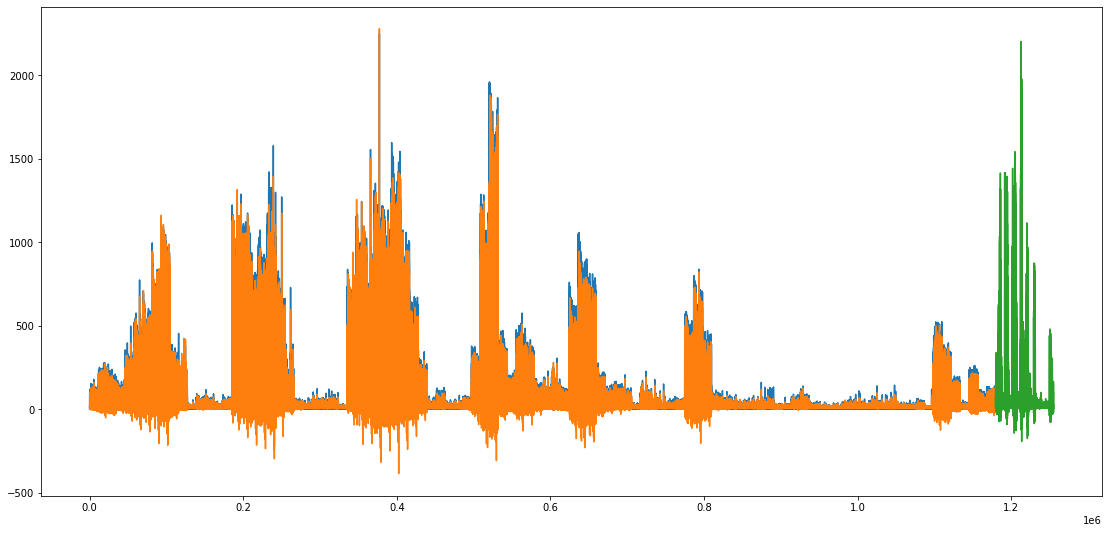

In [132]:
fig, ax = subplots(1, 1, figsize=(19, 9))
ax_reshape = [ax]

ax_reshape[0].plot(range(len(y_train)), y_train[('region', 'lag_plus_1')].values)
ax_reshape[0].plot(range(len(y_train_pred)), y_train_pred)

ax_reshape[0].plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred)



### Вывод:
* визуально ничего не понятно, так как здесь собраны все ряды всех регионов

### выберем один регион

In [133]:
df_train_result = df_train[[('region', 'id'), ('region', 'lag_plus_1')]].copy()
df_train_result['pred'] = y_train_pred
df_train_result = df_train_result[df_train_result[('region', 'id')] == empire_state_building_region]
df_train_result

region                   pred
                         id lag_plus_1            
tpep_pickup_datetime                              
2015-01-05 00:00:00    1231      120.0  136.019728
2015-01-05 01:00:00    1231       42.0   90.396177
2015-01-05 02:00:00    1231       56.0   46.933373
2015-01-05 03:00:00    1231       57.0  100.646538
2015-01-05 04:00:00    1231       92.0  150.417892
...                     ...        ...         ...
2016-04-30 18:00:00    1231      892.0  831.417636
2016-04-30 19:00:00    1231      779.0  647.535384
2016-04-30 20:00:00    1231      793.0  752.355178
2016-04-30 21:00:00    1231      884.0  840.309260
2016-04-30 22:00:00    1231      785.0  684.393062

[11567 rows x 3 columns]

In [134]:
df_test_result = df_test[[('region', 'id'), ('region', 'lag_plus_1')]].copy()
df_test_result['pred'] = y_pred
df_test_result = df_test_result[df_test_result[('region', 'id')] == empire_state_building_region]
df_test_result

region                    pred
                         id lag_plus_1             
tpep_pickup_datetime                               
2016-04-30 23:00:00    1231      881.0   797.570384
2016-05-01 00:00:00    1231      713.0   669.410388
2016-05-01 01:00:00    1231      533.0   473.867408
2016-05-01 02:00:00    1231      418.0   354.819842
2016-05-01 03:00:00    1231      353.0   261.992034
...                     ...        ...          ...
2016-05-31 13:00:00    1231     1009.0   868.439218
2016-05-31 14:00:00    1231      814.0   644.901625
2016-05-31 15:00:00    1231      748.0   716.872201
2016-05-31 16:00:00    1231      879.0   902.143733
2016-05-31 17:00:00    1231     1093.0  1100.133496

[739 rows x 3 columns]

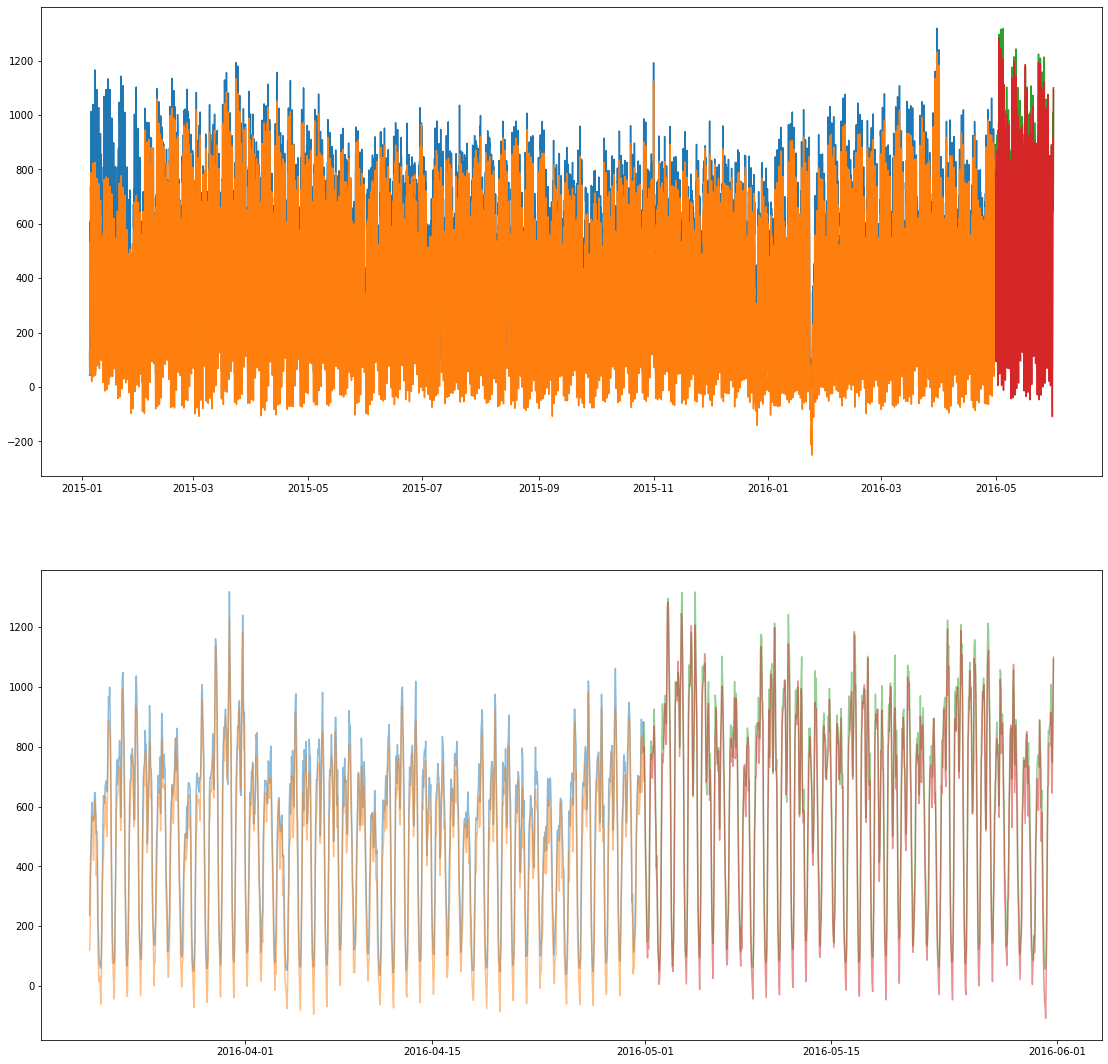

In [135]:
fig, ax = subplots(2, 1, figsize=(19, 19))
ax_reshape = ax.reshape(-1)

ax_reshape[0].plot(df_train_result[('region', 'lag_plus_1')])
ax_reshape[0].plot(df_train_result[('pred', '')])

ax_reshape[0].plot(df_test_result[('region', 'lag_plus_1')])
ax_reshape[0].plot(df_test_result[('pred', '')])


max_len = 1000

ax_reshape[1].plot(df_train_result[('region', 'lag_plus_1')][-max_len:], alpha=0.5)
ax_reshape[1].plot(df_train_result[('pred', '')][-max_len:], alpha=0.5)

ax_reshape[1].plot(df_test_result[('region', 'lag_plus_1')][:max_len], alpha=0.5)
ax_reshape[1].plot(df_test_result[('pred', '')][:max_len], alpha=0.5)


In [176]:
# сохраненные гипер-параметры после перебора по сетке

# {0: {'best_score': 26.9850915843787,
#   'best_params': {'alpha': 1,
#    'tol': 0.0001,
#    'normalize': False,
#    'selection': 'random'},
#   'best_estimator': Lasso(alpha=1, selection='random')},
#  1: {'best_score': 42.5848898685642,
#   'best_params': {'alpha': 1,
#    'tol': 0.0001,
#    'normalize': False,
#    'selection': 'cyclic'},
#   'best_estimator': Lasso(alpha=1)},
#  2: {'best_score': 51.22004324581977,
#   'best_params': {'alpha': 1,
#    'tol': 0.0001,
#    'normalize': False,
#    'selection': 'random'},
#   'best_estimator': Lasso(alpha=1, selection='random')},
#  3: {'best_score': 53.99450243060681,
#   'best_params': {'alpha': 1,
#    'tol': 0.0001,
#    'normalize': False,
#    'selection': 'cyclic'},
#   'best_estimator': Lasso(alpha=1)},
#  4: {'best_score': 52.64427726954412,
#   'best_params': {'alpha': 1,
#    'tol': 0.0001,
#    'normalize': False,
#    'selection': 'cyclic'},
#   'best_estimator': Lasso(alpha=1)},
#  5: {'best_score': 48.96232540595154,
#   'best_params': {'alpha': 1,
#    'tol': 0.0001,
#    'normalize': False,
#    'selection': 'cyclic'},
#   'best_estimator': Lasso(alpha=1)}}

In [136]:


param_grid = {
    Lasso: {
        'alpha': 
    #         [10**i for i in range(-5, 3)], 
            [0.01], 
        'tol': 
    #         [10**i for i in range(-5, 1)],
            [10**-4],
        'normalize': [
            False, 
    #         True,
        ],
        'selection': [
    #         'cyclic', 
            'random',
        ],
    },
    
#     Ridge: {
#     },
    
#     RandomForest: {
#     },
    
}

# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.svm import LinearSVR


len(list(it.product(*[param_grid[model_class][p] for p in param_grid[model_class]])))


1

In [137]:
print(list(it.product(param_grid[model_class])))

[('alpha',), ('tol',), ('normalize',), ('selection',)]


In [138]:
# %%time

warnings.filterwarnings('ignore')

models = {}

model_class = Lasso

if __model_rows is None:
    max_len = len(X_train)
else:
    max_len = __model_rows
    
for n_model in range(N_pred):
    print(n_model)
    
    models[n_model] = {}
    
    if __use_1_model:
        models[n_model]['best_params'] = None
        models[n_model]['best_score'] = None
        models[n_model]['best_estimator'] = model_default
        continue

    column_name_current = f'lag_plus_{n_model + 1}'
        
    models[n_model]['best_score'] = None
    
    for param_set in it.product(*[param_grid[model_class][p] for p in param_grid[model_class]]):

        current_params = {param_name: param_set[i] for i, param_name in enumerate(param_grid[model_class])}
        print(current_params)

        model_current = model_class(**current_params)

        model_current.fit(X_train[:max_len], y_train[('region', column_name_current)][:max_len])

        y_pred = model_current.predict(X_test_05[:max_len])

        current_score = mean_absolute_error(y_test_05[('region', column_name_current)], y_pred)
        print(current_score)

        if (models[n_model]['best_score'] is None) or (models[n_model]['best_score'] > current_score):
            models[n_model]['best_params'] = current_params
            models[n_model]['best_score'] = current_score
            models[n_model]['best_estimator'] = model_current

    print(models[n_model])
            
warnings.filterwarnings('default')

models



0
{'alpha': 0.01, 'tol': 0.0001, 'normalize': False, 'selection': 'random'}
12.154694611586024
{'best_score': 12.154694611586024, 'best_params': {'alpha': 0.01, 'tol': 0.0001, 'normalize': False, 'selection': 'random'}, 'best_estimator': Lasso(alpha=0.01, selection='random')}
1
{'alpha': 0.01, 'tol': 0.0001, 'normalize': False, 'selection': 'random'}
13.087087784785123
{'best_score': 13.087087784785123, 'best_params': {'alpha': 0.01, 'tol': 0.0001, 'normalize': False, 'selection': 'random'}, 'best_estimator': Lasso(alpha=0.01, selection='random')}
2
{'alpha': 0.01, 'tol': 0.0001, 'normalize': False, 'selection': 'random'}
12.958123994476804
{'best_score': 12.958123994476804, 'best_params': {'alpha': 0.01, 'tol': 0.0001, 'normalize': False, 'selection': 'random'}, 'best_estimator': Lasso(alpha=0.01, selection='random')}
3
{'alpha': 0.01, 'tol': 0.0001, 'normalize': False, 'selection': 'random'}
12.728830970246943
{'best_score': 12.728830970246943, 'best_params': {'alpha': 0.01, 'tol': 0

{0: {'best_score': 12.154694611586024,
  'best_params': {'alpha': 0.01,
   'tol': 0.0001,
   'normalize': False,
   'selection': 'random'},
  'best_estimator': Lasso(alpha=0.01, selection='random')},
 1: {'best_score': 13.087087784785123,
  'best_params': {'alpha': 0.01,
   'tol': 0.0001,
   'normalize': False,
   'selection': 'random'},
  'best_estimator': Lasso(alpha=0.01, selection='random')},
 2: {'best_score': 12.958123994476804,
  'best_params': {'alpha': 0.01,
   'tol': 0.0001,
   'normalize': False,
   'selection': 'random'},
  'best_estimator': Lasso(alpha=0.01, selection='random')},
 3: {'best_score': 12.728830970246943,
  'best_params': {'alpha': 0.01,
   'tol': 0.0001,
   'normalize': False,
   'selection': 'random'},
  'best_estimator': Lasso(alpha=0.01, selection='random')},
 4: {'best_score': 12.723039528220838,
  'best_params': {'alpha': 0.01,
   'tol': 0.0001,
   'normalize': False,
   'selection': 'random'},
  'best_estimator': Lasso(alpha=0.01, selection='random')},


In [139]:
for n_model in range(N_pred):
    print(max(abs(models[n_model]['best_estimator'].coef_)))

2.6057190483056925
4.0796600252399555
4.157889456187266
3.7936403241838796
9.554187982665294
20.10670372225048


c:\users\17287618\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 4. Выбранными моделями постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза по следующему функционалу: 
$
Q_{may} =\frac1{R * 739* 6} \sum\limits_{r=1}^{R} \sum_{T=2016.04.30 23:00}^{2016.05.31 17:00} \sum_{i=1}^6 \left| \hat{y}^r_{T|T+i} - y^r_{T+i} \right|.
$


### оценки прогнозов ARIMA предыдущего занятия:
* расчет по моей функции = 32.9

### в оценках прогнозов этого занятия - в комментариях оставил историю того, как менялись результаты при добавлении разных блоков данных

### подготовка эталонных данных для подсчета результата

In [140]:
R = 102
history_len = 739

In [141]:
n_04_31_hours = 1 # (2016.04.30 23:00)
n_full_days_hours = 30 * 24 # (2016.05.01 00:00 .. 2016.05.30 23:00)
n_05_31_hours = 18 # (2016.05.31 00:00 .. 17:00)

n_total_hours_05 = n_04_31_hours + n_full_days_hours + n_05_31_hours
print(f'n_total_hours={n_total_hours_05}')

n_pred = 6

n_total_hours_pred = n_total_hours_05 * n_pred
print(f'n_total_hours_pred={n_total_hours_pred}')

n_zones = 102

n_total_hours_zones = n_total_hours_05 * n_zones
print(f'n_total_hours_zones={n_total_hours_zones}')

n_total_hours_pred_zones = n_total_hours_pred * n_zones
print(f'n_total_hours_pred_zones={n_total_hours_pred_zones}')


n_total_hours=739
n_total_hours_pred=4434
n_total_hours_zones=75378
n_total_hours_pred_zones=452268


In [142]:
n_05_31_hours = 1 # (2016.05.31 23:00)
n_full_days_hours = 29 * 24 # (2016.06.01 00:00 .. 2016.06.29 23:00)
n_06_30_hours = 18 # (2016.06.30 00:00 .. 17:00)

n_total_hours_06 = n_05_31_hours + n_full_days_hours + n_06_30_hours
print(f'n_total_hours={n_total_hours_06}')

n_pred = 6

n_total_hours_pred = n_total_hours_06 * n_pred
print(f'n_total_hours_pred={n_total_hours_pred}')

n_zones = 102

n_total_hours_zones = n_total_hours_06 * n_zones
print(f'n_total_hours_zones={n_total_hours_zones}')

n_total_hours_pred_zones = n_total_hours_pred * n_zones
print(f'n_total_hours_pred_zones={n_total_hours_pred_zones}')

print(f'437580 - n_total_hours_pred_zones={437580 - n_total_hours_pred_zones}')



n_total_hours=715
n_total_hours_pred=4290
n_total_hours_zones=72930
n_total_hours_pred_zones=437580
437580 - n_total_hours_pred_zones=0


In [143]:
regions_102 

array([1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132,
       1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182,
       1183, 1184, 1221, 1222, 1223, 1224, 1225, 1227, 1228, 1229, 1230,
       1231, 1232, 1233, 1234, 1235, 1272, 1273, 1274, 1278, 1279, 1280,
       1281, 1282, 1283, 1284, 1285, 1286, 1287, 1326, 1327, 1331, 1332,
       1333, 1334, 1335, 1336, 1337, 1338, 1339, 1376, 1377, 1378, 1380,
       1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1426, 1431,
       1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1480, 1482, 1483,
       1530, 1532, 1533, 1580, 1630, 1684, 1733, 1734, 1783, 2068, 2069,
       2118, 2119, 2168])

In [144]:
start_date_time = datetime.datetime.strptime('2016-04-30 23:00:00', "%Y-%m-%d %H:%M:%S")

history_end_2016_05 = [start_date_time + datetime.timedelta(hours = hours_n) for hours_n in range(n_total_hours_05)]

len(history_end_2016_05), history_end_2016_05[0], history_end_2016_05[-1]

(739,
 datetime.datetime(2016, 4, 30, 23, 0),
 datetime.datetime(2016, 5, 31, 17, 0))

In [145]:
start_date_time = datetime.datetime.strptime('2016-05-31 23:00:00', "%Y-%m-%d %H:%M:%S")

history_end_2016_06 = [start_date_time + datetime.timedelta(hours = hours_n) for hours_n in range(n_total_hours_06)]

len(history_end_2016_06), history_end_2016_06[0], history_end_2016_06[-1]

(715,
 datetime.datetime(2016, 5, 31, 23, 0),
 datetime.datetime(2016, 6, 30, 17, 0))

In [146]:
df_2016_05_102_pivot = df_pivot[(df_pivot.index >= '2016-04-30 23:00:00') & (df_pivot.index <= '2016-05-31 23:00:00')]
df_2016_05_102_pivot

1075   1076   1077  1125   1126   1127   1128    1129  \
                      count  count  count count  count  count  count   count   
tpep_pickup_datetime                                                           
2016-04-30 23:00:00    77.0  100.0   56.0  68.0  238.0  451.0  599.0   706.0   
2016-05-01 00:00:00    71.0   64.0   52.0  81.0  259.0  535.0  691.0   994.0   
2016-05-01 01:00:00    37.0   39.0   13.0  38.0  121.0  465.0  686.0  1024.0   
2016-05-01 02:00:00    10.0   46.0    8.0  34.0   86.0  410.0  621.0   843.0   
2016-05-01 03:00:00    14.0   25.0    6.0  23.0   59.0  241.0  355.0   591.0   
...                     ...    ...    ...   ...    ...    ...    ...     ...   
2016-05-31 19:00:00   106.0  167.0  171.0  88.0  293.0  401.0  433.0   284.0   
2016-05-31 20:00:00    99.0  166.0  165.0  65.0  301.0  350.0  404.0   351.0   
2016-05-31 21:00:00    84.0  173.0  107.0  78.0  256.0  340.0  416.0   426.0   
2016-05-31 22:00:00    83.0   98.0  127.0  94.0  174.0  345.0  415.0   411.0   
2016-05-31 23:00:00    34.0   77.0   58.0  53.0  118.0  211.0  331.0   338.0   

                        1130   1131  ...         2168               \
                       count  count  ... lag_minus_48 lag_minus_72   
tpep_pickup_datetime                 ...                             
2016-04-30 23:00:00    786.0  158.0  ...         70.0         43.0   
2016-05-01 00:00:00   1100.0  193.0  ...         47.0         44.0   
2016-05-01 01:00:00   1292.0  310.0  ...         48.0         27.0   
2016-05-01 02:00:00   1368.0  327.0  ...          0.0          9.0   
2016-05-01 03:00:00   1250.0  342.0  ...          0.0          2.0   
...                      ...    ...  ...          ...          ...   
2016-05-31 19:00:00    428.0  222.0  ...         95.0         77.0   
2016-05-31 20:00:00    444.0  190.0  ...        116.0         84.0   
2016-05-31 21:00:00    493.0  173.0  ...        131.0        107.0   
2016-05-31 22:00:00    490.0  144.0  ...        137.0         97.0   
2016-05-31 23:00:00    434.0  121.0  ...        112.0         71.0   

                                                                     \
                     lag_minus_96 lag_sum_12 lag_sum_24 lag_sum_168   
tpep_pickup_datetime                                                  
2016-04-30 23:00:00          67.0      744.0     1194.0      8452.0   
2016-05-01 00:00:00          46.0      784.0     1213.0      8507.0   
2016-05-01 01:00:00          31.0      768.0     1228.0      8537.0   
2016-05-01 02:00:00           0.0      719.0     1228.0      8537.0   
2016-05-01 03:00:00           0.0      686.0     1228.0      8537.0   
...                           ...        ...        ...         ...   
2016-05-31 19:00:00          71.0     1134.0     2350.0     10753.0   
2016-05-31 20:00:00          84.0     1103.0     2299.0     10812.0   
2016-05-31 21:00:00         122.0     1131.0     2267.0     10871.0   
2016-05-31 22:00:00         116.0     1147.0     2214.0     10919.0   
2016-05-31 23:00:00          83.0     1251.0     2177.0     11029.0   

                                                                       
                     lag_sum_672 lag_mean_24 lag_median_24 lag_std_24  
tpep_pickup_datetime                                                   
2016-04-30 23:00:00      31858.0   49.750000          51.5  29.014614  
2016-05-01 00:00:00      31930.0   50.541667          51.5  29.727720  
2016-05-01 01:00:00      31949.0   51.166667          51.5  29.210877  
2016-05-01 02:00:00      31927.0   51.166667          51.5  29.210877  
2016-05-01 03:00:00      31923.0   51.166667          51.5  29.210877  
...                          ...         ...           ...        ...  
2016-05-31 19:00:00      44583.0   97.916667         102.5  51.389321  
2016-05-31 20:00:00      44611.0   95.791667         102.5  49.649186  
2016-05-31 21:00:00      44649.0   94.458333         102.5  48.202453  
2016-05-31 22:00:00      44671.0   92.250000         102.5  45

In [147]:
result_2016_05_true = {}

for region_index, region_n in tqdm.tqdm(enumerate(regions_102)):
    result_2016_05_true[region_n] = {}
    
    for history_index, history_end in enumerate(history_end_2016_05):
        result_2016_05_true[region_n][history_end] = df_2016_05_102_pivot[(region_n, 'count')].values[history_index : history_index + n_pred]

len(result_2016_05_true)

c:\users\17287618\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
102it [00:05, 19.04it/s]


102

### собственно функции расчета

сделано 2 варианта расчета:
* через словарь (регион/время/лаг)
* через сравнение датасетов

результаты функций немного различаются, так и не смог понять почему :(

но через датасеты - дает результат, более близкий к kaggle

In [148]:
def calc_score_dict(y_pred, y_true):
    score = 0
    for region_n in y_pred:
        for history_end in y_pred[region_n]:
            for pred_n in range(n_pred):  
                score += abs(y_pred[region_n][history_end][pred_n] - y_true[region_n][history_end][pred_n])
                
    return score / (len(y_pred) * len(y_pred[list(y_pred.keys())[0]]) * n_pred)


In [149]:
def calc_score_df(y_pred, y_true):
    score = 0

    for pred_n in range(len(y_pred)):  
        score += abs(y_pred[pred_n] - y_true[pred_n]).sum()
                
    return score / (len(y_pred[0]) * n_pred)


In [150]:
result_2016_05_0 = {}

for region_index, region_n in tqdm.tqdm(enumerate(regions_102)):
    result_2016_05_0[region_n] = {}
    
    for history_index, history_end in enumerate(history_end_2016_05):
        result_2016_05_0[region_n][history_end] = [0]* n_pred

len(result_2016_05_0)

102it [00:00, 454.70it/s]


102

### проверка расчетов на нулевых данных

In [151]:
y_test_0 = y_test_05.copy()
y_test_0.loc[:,:] = 0
y_test_0

region                                              \
                     lag_plus_1 lag_plus_2 lag_plus_3 lag_plus_4 lag_plus_5   
tpep_pickup_datetime                                                          
2016-04-30 23:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-01 00:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-01 01:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-01 02:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-01 03:00:00         0.0        0.0        0.0        0.0        0.0   
...                         ...        ...        ...        ...        ...   
2016-05-31 13:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-31 14:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-31 15:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-31 16:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-31 17:00:00         0.0        0.0        0.0        0.0        0.0   

                                 
                     lag_plus_6  
tpep_pickup_datetime             
2016-04-30 23:00:00         0.0  
2016-05-01 00:00:00         0.0  
2016-05-01 01:00:00         0.0  
2016-05-01 02:00:00         0.0  
2016-05-01 03:00:00         0.0  
...                         ...  
2016-05-31 13:00:00         0.0  
2016-05-31 14:00:00         0.0  
2016-05-31 15:00:00         0.0  
2016-05-31 16:00:00         0.0  
2016-05-31 17:00:00         0.0  

[75378 rows x 6 columns]

In [152]:
calc_score_df(y_test_0.values.T, y_test_05.values.T)

c:\users\17287618\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


151.04925619323058

In [153]:
calc_score_dict(result_2016_05_true, result_2016_05_0)

151.03221098994402

In [154]:
calc_score_df(y_test_05.values.T, y_test_05.values.T)

0.0

In [155]:
calc_score_dict(result_2016_05_true, result_2016_05_true)

0.0

### прогнозы моделей

In [156]:
%%time

y_pred_05 = []

for n_model in range(N_pred):
    y_pred_05.append(models[n_model]['best_estimator'].predict(X_test_05))
    
y_pred_05

Wall time: 647 ms


[array([ 73.77012974,  49.24982156,  22.09568055, ...,  91.03219211,
        103.23552069,  84.75757111]),
 array([ 53.28812636,  28.22557689,  15.63274248, ...,  86.68758551,
         83.1652217 , 115.44224065]),
 array([ 31.60924821,  18.46734112,  13.73487591, ...,  75.47593708,
        111.72705155, 142.15328463]),
 array([ 23.82352591,  16.05880052,   1.61095334, ..., 107.28552807,
        138.25153253, 149.17255021]),
 array([ 23.7609184 ,   0.63412598,   1.21858036, ..., 134.97066217,
        141.88976386, 127.57441365]),
 array([ 16.99171241,   8.05825025,  11.67984421, ..., 129.53869598,
        137.3926592 , 113.22545128])]

In [157]:
df_test_result = df_test[('region', 'id')].to_frame()

for n_model in range(N_pred):
    df_test_result[('prediction', n_model)] = y_pred_05[n_model]
    
df_test_result


c:\users\17287618\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


region  prediction                                      \
                         id           0           1           2           3   
tpep_pickup_datetime                                                          
2016-04-30 23:00:00    1075   73.770130   53.288126   31.609248   23.823526   
2016-05-01 00:00:00    1075   49.249822   28.225577   18.467341   16.058801   
2016-05-01 01:00:00    1075   22.095681   15.632742   13.734876    1.610953   
2016-05-01 02:00:00    1075   10.436558   12.131067    1.486387    2.432992   
2016-05-01 03:00:00    1075   17.527332    4.665141    5.210866   21.994932   
...                     ...         ...         ...         ...         ...   
2016-05-31 13:00:00    2168  108.905522  118.535761  110.873663   95.249980   
2016-05-31 14:00:00    2168   99.883990  104.051238   91.432044   79.689885   
2016-05-31 15:00:00    2168   91.032192   86.687586   75.475937  107.285528   
2016-05-31 16:00:00    2168  103.235521   83.165222  111.727052  138.251533   
2016-05-31 17:00:00    2168   84.757571  115.442241  142.153285  149.172550   

                                              
                               4           5  
tpep_pickup_datetime                          
2016-04-30 23:00:00    23.760918   16.991712  
2016-05-01 00:00:00     0.634126    8.058250  
2016-05-01 01:00:00     1.218580   11.679844  
2016-05-01 02:00:00    17.659908   25.267399  
2016-05-01 03:00:00    22.960882   23.283860  
...                          ...         ...  
2016-05-31 13:00:00    82.637025  100.504551  
2016-05-31 14:00:00   110.836955  119.335697  
2016-05-31 15:00:00   134.970662  129.538696  
2016-05-31 16:00:00   141.889764  137.392659  
2016-05-31 17:00:00   127.574414  113.225451  

[75378 rows x 7 columns]

In [158]:
%%time

result_2016_05_pred = {}

prediction_columns = [('prediction', n_model) for n_model in range(N_pred)]

for region_index, region_n in tqdm.tqdm(enumerate(regions_102)):
    result_2016_05_pred[region_n] = {}
    
    for history_index, history_end in enumerate(history_end_2016_05):
        result_2016_05_pred[region_n][history_end] = df_test_result[(df_test_result.index == history_end) & (df_test_result[('region', 'id')] == region_n)][prediction_columns].values[0]

len(result_2016_05_pred)

c:\users\17287618\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
102it [03:53,  2.29s/it]

Wall time: 3min 53s


102

### оценка прогнозов 

In [159]:
calc_score_dict(result_2016_05_pred, result_2016_05_true)

# 56.836 - дата, регион, лаги
# 45.1 - + sin cos
# 48.97 - + ARIMA
# 
# 31.38  - лаги ARIMA

c:\users\17287618\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


31.386025418668464

In [160]:
calc_score_df(y_pred_05, y_test_05.values.T)

# 70.468 - дата, регион, лаги
# 46.06 - + sin cos
# 45.91 - + ARIMA
# 34.7 - много колонок
# 13.7 - лаги ARIMA

13.70968316247333

### регрессия иногда выдает отрицательные прогнозы

In [161]:
y_test_05[y_test_05 < 0].sum()

region  lag_plus_1    0.0
        lag_plus_2    0.0
        lag_plus_3    0.0
        lag_plus_4    0.0
        lag_plus_5    0.0
        lag_plus_6    0.0
dtype: float64

In [162]:
y_pred_05 = np.array(y_pred_05)
y_pred_05[y_pred_05 < 0].sum()

c:\users\17287618\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-49561.13214476081

In [163]:
y_pred_05[y_pred_05 < 0] = 0
y_pred_05

array([[ 73.77012974,  49.24982156,  22.09568055, ...,  91.03219211,
        103.23552069,  84.75757111],
       [ 53.28812636,  28.22557689,  15.63274248, ...,  86.68758551,
         83.1652217 , 115.44224065],
       [ 31.60924821,  18.46734112,  13.73487591, ...,  75.47593708,
        111.72705155, 142.15328463],
       [ 23.82352591,  16.05880052,   1.61095334, ..., 107.28552807,
        138.25153253, 149.17255021],
       [ 23.7609184 ,   0.63412598,   1.21858036, ..., 134.97066217,
        141.88976386, 127.57441365],
       [ 16.99171241,   8.05825025,  11.67984421, ..., 129.53869598,
        137.3926592 , 113.22545128]])

In [164]:
calc_score_df(y_pred_05, y_test_05.values.T)

# 70.38 - дата, регион, лаги
# 43.88 - + sin cos
# 42.76 - + ARIMA
# 32.6 - много колонок
# 13.6 - лаги ARIMA

13.600099614345318

### Вывод:
* заменив отрицательные пронозы на 0 - можно немного улучшить результат (в первом знаке после десятичной запятой)

### Итого:
* было: 32.9
* стало 13.6

# 5. Итоговыми моделями постройте прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

### оценки прогнозов ARIMA предыдущего занятия:
* расчет по моей функции = 32.18
* submission на kaggle = 37.38269

### данные для оценки

In [165]:
df_2016_06_102_pivot = df_pivot[(df_pivot.index >= '2016-05-31 23:00:00') & (df_pivot.index <= '2016-06-30 23:00:00')]
df_2016_06_102_pivot

1075   1076   1077   1125   1126   1127   1128   1129  \
                      count  count  count  count  count  count  count  count   
tpep_pickup_datetime                                                           
2016-05-31 23:00:00    34.0   77.0   58.0   53.0  118.0  211.0  331.0  338.0   
2016-06-01 00:00:00    26.0   30.0   19.0   39.0   71.0  163.0  181.0  219.0   
2016-06-01 01:00:00    14.0   21.0    6.0   26.0   49.0  101.0  136.0  144.0   
2016-06-01 02:00:00     5.0   25.0    4.0   18.0   25.0   42.0   74.0  123.0   
2016-06-01 03:00:00     2.0    5.0    3.0    4.0   16.0   36.0   36.0   85.0   
...                     ...    ...    ...    ...    ...    ...    ...    ...   
2016-06-30 19:00:00   116.0  190.0  135.0  132.0  395.0  308.0  401.0  336.0   
2016-06-30 20:00:00   104.0  142.0  149.0  141.0  333.0  368.0  390.0  385.0   
2016-06-30 21:00:00   151.0  162.0  145.0  135.0  359.0  422.0  460.0  541.0   
2016-06-30 22:00:00   106.0  168.0  103.0  125.0  317.0  476.0  405.0  508.0   
2016-06-30 23:00:00    85.0  130.0   86.0  113.0  256.0  428.0  483.0  531.0   

                       1130   1131  ...         2168               \
                      count  count  ... lag_minus_48 lag_minus_72   
tpep_pickup_datetime                ...                             
2016-05-31 23:00:00   434.0  121.0  ...        112.0         71.0   
2016-06-01 00:00:00   326.0   56.0  ...         85.0         54.0   
2016-06-01 01:00:00   252.0   27.0  ...         38.0         29.0   
2016-06-01 02:00:00   245.0   30.0  ...         15.0          0.0   
2016-06-01 03:00:00   241.0   24.0  ...          0.0          1.0   
...                     ...    ...  ...          ...          ...   
2016-06-30 19:00:00   496.0  260.0  ...          1.0          0.0   
2016-06-30 20:00:00   560.0  247.0  ...          0.0          0.0   
2016-06-30 21:00:00   672.0  259.0  ...          0.0          1.0   
2016-06-30 22:00:00   578.0  259.0  ...          0.0          1.0   
2016-06-30 23:00:00   631.0  210.0  ...          1.0          1.0   

                                                                     \
                     lag_minus_96 lag_sum_12 lag_sum_24 lag_sum_168   
tpep_pickup_datetime                                                  
2016-05-31 23:00:00          83.0     1251.0     2177.0     11029.0   
2016-06-01 00:00:00          71.0     1251.0     2117.0     11074.0   
2016-06-01 01:00:00          45.0     1172.0     2084.0     11074.0   
2016-06-01 02:00:00          10.0     1108.0     2094.0     11084.0   
2016-06-01 03:00:00           0.0     1032.0     2094.0     11084.0   
...                           ...        ...        ...         ...   
2016-06-30 19:00:00           2.0       10.0       28.0       227.0   
2016-06-30 20:00:00           1.0        9.0       27.0       227.0   
2016-06-30 21:00:00           5.0       10.0       28.0       228.0   
2016-06-30 22:00:00           6.0        9.0       27.0       227.0   
2016-06-30 23:00:00           5.0        9.0       27.0       226.0   

                                                                       
                     lag_sum_672 lag_mean_24 lag_median_24 lag_std_24  
tpep_pickup_datetime                                                   
2016-05-31 23:00:00      44693.0   90.708333         102.5  43.299241  
2016-06-01 00:00:00      44729.0   88.208333          97.5  41.732043  
2016-06-01 01:00:00      44737.0   86.833333          97.5  42.718153  
2016-06-01 02:00:00      44746.0   87.250000          97.5  41.874813  
2016-06-01 03:00:00      44746.0   87.250000          97.5  41.874813  
...                          ...         ...           ...        ...  
2016-06-30 19:00:00      19052.0    1.166667           1.0   1.403928  
2016-06-30 20:00:00      18969.0    1.125000           1.0   1.423789  
2016-06-30 21:00:00      18876.0    1.166667           1.0   1.403928  
2016-06-30 22:00:00      18761.0    1.125000           1.0   1.423789  
2016

In [166]:
result_2016_06_true = {}

for region_index, region_n in tqdm.tqdm(enumerate(regions_102)):
    result_2016_06_true[region_n] = {}
    
    for history_index, history_end in enumerate(history_end_2016_06):
        result_2016_06_true[region_n][history_end] = df_2016_06_102_pivot[(region_n, 'count')].values[history_index : history_index + n_pred]

len(result_2016_06_true)

c:\users\17287618\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
102it [00:04, 21.34it/s]


102

### прогнозы моделей

In [167]:
%%time

y_pred_06 = []

for n_model in range(N_pred):
    y_pred_06.append(models[n_model]['best_estimator'].predict(X_val_06))
    
y_pred_06

Wall time: 633 ms


[array([13.22649661, 11.32885292,  1.84852348, ..., 34.92752925,
        37.63334415, 56.10085079]),
 array([ 5.30631495, -1.26422981, -3.50260749, ..., 51.81659373,
        63.94093738, 84.84797258]),
 array([ -1.91117168,  -5.20572788,   2.59882857, ...,  70.03672409,
         84.85984442, 100.41326815]),
 array([ -3.86815875,   0.13732727,   5.88904921, ...,  85.41903837,
         94.5569286 , 106.52798535]),
 array([ 1.34845235,  3.68519865, 16.67132507, ..., 95.3500871 ,
        99.14873008, 93.21115251]),
 array([ 5.80150231, 18.4200761 , 40.10785719, ..., 88.22126535,
        87.12718529, 68.85603367])]

In [168]:
y_pred_06 = np.array(y_pred_06)
y_pred_06[y_pred_06 < 0] = 0
y_pred_06

c:\users\17287618\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 13.22649661,  11.32885292,   1.84852348, ...,  34.92752925,
         37.63334415,  56.10085079],
       [  5.30631495,   0.        ,   0.        , ...,  51.81659373,
         63.94093738,  84.84797258],
       [  0.        ,   0.        ,   2.59882857, ...,  70.03672409,
         84.85984442, 100.41326815],
       [  0.        ,   0.13732727,   5.88904921, ...,  85.41903837,
         94.5569286 , 106.52798535],
       [  1.34845235,   3.68519865,  16.67132507, ...,  95.3500871 ,
         99.14873008,  93.21115251],
       [  5.80150231,  18.4200761 ,  40.10785719, ...,  88.22126535,
         87.12718529,  68.85603367]])

### оценка прогноза

In [169]:
y_val_06

region                                              \
                     lag_plus_1 lag_plus_2 lag_plus_3 lag_plus_4 lag_plus_5   
tpep_pickup_datetime                                                          
2016-05-31 23:00:00        26.0       14.0        5.0        2.0        1.0   
2016-06-01 00:00:00        14.0        5.0        2.0        1.0        7.0   
2016-06-01 01:00:00         5.0        2.0        1.0        7.0       23.0   
2016-06-01 02:00:00         2.0        1.0        7.0       23.0       34.0   
2016-06-01 03:00:00         1.0        7.0       23.0       34.0       72.0   
...                         ...        ...        ...        ...        ...   
2016-06-30 13:00:00         0.0        0.0        2.0        1.0        1.0   
2016-06-30 14:00:00         0.0        2.0        1.0        1.0        1.0   
2016-06-30 15:00:00         2.0        1.0        1.0        1.0        0.0   
2016-06-30 16:00:00         1.0        1.0        1.0        0.0        1.0   
2016-06-30 17:00:00         1.0        1.0        0.0        1.0        0.0   

                                 
                     lag_plus_6  
tpep_pickup_datetime             
2016-05-31 23:00:00         7.0  
2016-06-01 00:00:00        23.0  
2016-06-01 01:00:00        34.0  
2016-06-01 02:00:00        72.0  
2016-06-01 03:00:00        54.0  
...                         ...  
2016-06-30 13:00:00         1.0  
2016-06-30 14:00:00         0.0  
2016-06-30 15:00:00         1.0  
2016-06-30 16:00:00         0.0  
2016-06-30 17:00:00         0.0  

[72930 rows x 6 columns]

In [170]:
df_val_result = df_val[('region', 'id')].to_frame()

for n_model in range(N_pred):
    df_val_result[('prediction', n_model)] = y_pred_06[n_model]
    
df_val_result


c:\users\17287618\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


region prediction                                     \
                         id          0          1           2           3   
tpep_pickup_datetime                                                        
2016-05-31 23:00:00    1075  13.226497   5.306315    0.000000    0.000000   
2016-06-01 00:00:00    1075  11.328853   0.000000    0.000000    0.137327   
2016-06-01 01:00:00    1075   1.848523   0.000000    2.598829    5.889049   
2016-06-01 02:00:00    1075   0.000000   2.507291    6.529172   15.835731   
2016-06-01 03:00:00    1075   4.089262   6.459285   16.451889   46.944120   
...                     ...        ...        ...         ...         ...   
2016-06-30 13:00:00    2168  34.708585  74.728124   64.598707   56.327309   
2016-06-30 14:00:00    2168  65.735243  63.437106   62.276039   71.392089   
2016-06-30 15:00:00    2168  34.927529  51.816594   70.036724   85.419038   
2016-06-30 16:00:00    2168  37.633344  63.940937   84.859844   94.556929   
2016-06-30 17:00:00    2168  56.100851  84.847973  100.413268  106.527985   

                                            
                              4          5  
tpep_pickup_datetime                        
2016-05-31 23:00:00    1.348452   5.801502  
2016-06-01 00:00:00    3.685199  18.420076  
2016-06-01 01:00:00   16.671325  40.107857  
2016-06-01 02:00:00   47.836087  64.773420  
2016-06-01 03:00:00   72.128776  55.496201  
...                         ...        ...  
2016-06-30 13:00:00   66.243865  67.969152  
2016-06-30 14:00:00   86.687198  80.228122  
2016-06-30 15:00:00   95.350087  88.221265  
2016-06-30 16:00:00   99.148730  87.127185  
2016-06-30 17:00:00   93.211153  68.856034  

[72930 rows x 7 columns]

In [171]:
%%time

result_2016_06_pred = {}

prediction_columns = [('prediction', n_model) for n_model in range(N_pred)]

for region_index, region_n in tqdm.tqdm(enumerate(regions_102)):
    result_2016_06_pred[region_n] = {}
    
    for history_index, history_end in enumerate(history_end_2016_06):
        result_2016_06_pred[region_n][history_end] = df_val_result[(df_val_result.index == history_end) & (df_val_result[('region', 'id')] == region_n)][prediction_columns].values[0]

len(result_2016_06_pred)

c:\users\17287618\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
102it [03:47,  2.23s/it]

Wall time: 3min 47s


102

In [172]:
calc_score_dict(result_2016_06_true, result_2016_06_pred)

# 54.968 - дата, регион, лаги
# 41.47 - + sin cos
# 45.58 - + ARIMA
# 
# 36.5 - лаги ARIMA

c:\users\17287618\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


36.59976591743281

In [173]:
calc_score_df(y_pred_06, y_val_06.values.T)

# 68.009 - дата, регион, лаги
# 42.016 - + sin cos
# 42.117 - + ARIMA
# 31.6 - много колонок
# 26.14 - лаги ARIMA

26.14735341406956

In [174]:
submission_5_05_arima_lags = create_submission(result_2016_06_pred)
submission_5_05_arima_lags

,id,y
0,1075_2016-05-31_23_1,13.226497
1,1075_2016-05-31_23_2,5.306315
2,1075_2016-05-31_23_3,0.000000
3,1075_2016-05-31_23_4,0.000000
4,1075_2016-05-31_23_5,1.348452
...,...,...
437575,2168_2016-06-30_17_2,84.847973
437576,2168_2016-06-30_17_3,100.413268
437577,2168_2016-06-30_17_4,106.527985
437578,2168_2016-06-30_17_5,93.211153


In [175]:
submission_5_05_arima_lags.to_csv('submission_5_05_arima_lags.csv', header=True, index=None)

# Score 64.07814 - дата, регион, лаги
# 42.01686 - sin cos
# 42.11742 - ARIMA
# 31.68 - много колонок
# 26.14734 - лаги ARIMA

c:\users\17287618\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Итого:
* расчет по моей функции
    * было: 32.18
    * стало 26.14
* submission на kaggle
    * было: 37.38269
    * стало 26.14734


# 6. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

* не нашел, как сделать доступным свой submission
* вот ссылка https://www.kaggle.com/c/yellowtaxi/submissions, но это общий список всех открытых submission
* сделаю скрин-шот экрана :)

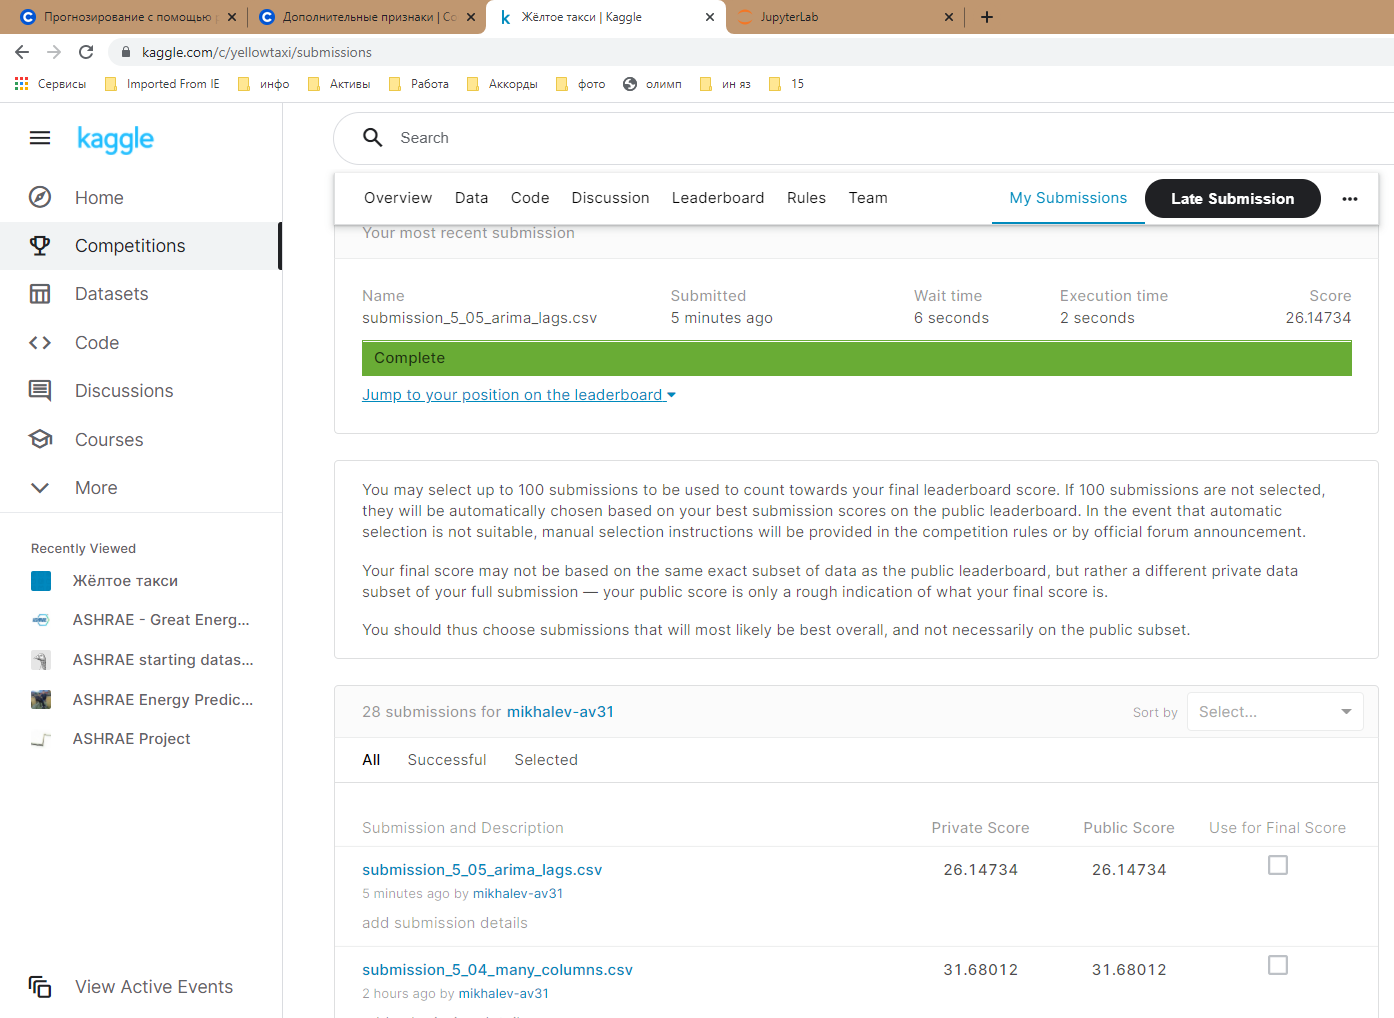
